

![image-20201226152702981](images/image-20201226152702981.png)


数据集State-of-the-Art详见

- [mnist](https://paperswithcode.com/sota/image-classification-on-mnist)
- [fashion-mnist](https://paperswithcode.com/sota/image-classification-on-fashion-mnist)
- [cifar-10](https://paperswithcode.com/sota/image-classification-on-cifar-10)


## Configuration


In [40]:
%%bash
 
# pip install -U ipyparams 
#pip install -U tensorflow_hub 
#pip install -U ipython
# pip install -U pymysql pyodbc
# pip install -U fasttext
# pip install -U seaborn

In [41]:
import csv
import ipyparams
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import re
import shutil
import string  
import sys
import tensorflow as tf
import tensorflow_hub as hub

from collections import Counter
from joblib import Parallel, delayed
from scipy import stats
from sklearn import feature_extraction, feature_selection
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model, models, layers, regularizers, preprocessing, datasets, metrics, losses, optimizers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorboard.plugins.hparams import api as hp 
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from PIL import Image 

base_path = os.path.abspath('/tf/eipi10/jian-xu3/qbz95')
sys.path.append(base_path)

import qbz95
from qbz95 import tf as qtf

pd.set_option('display.max_colwidth', None)
# set gpu memory
qtf.utils.set_gpu_memory_growth()

# auto load the changes of referenced codes
%load_ext autoreload
%autoreload 2

# ebablbe auto-completion
%config Completer.use_jedi = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
%reload_ext autoreload

### Initial Parameters

In [43]:
def lr_schedule(epoch, lr):
    """config the strategy of reducing learning rate"""
    lr_times = [(0, 1), (60, 1e-1), (90, 1e-2), (105, 1e-3), (120, 0.5e-3)]
    
    base_lr = 1e-3
    new_lr = base_lr
    for border_epoch, times in lr_times:
        if epoch>=border_epoch: 
            new_lr = base_lr*times
    if abs(lr - new_lr)>1e-7:
        if new_lr > lr > 0.1*new_lr - 1e-7:
            print('Epoch %05d: Still keep learning rate %s instead of %s' % 
                  (epoch + 1, round(lr, 7), round(new_lr, 7))) 
            return lr   
        print('Epoch %05d: LearningRateScheduler reducing learning rate to %s from %s.' % 
              (epoch + 1, round(new_lr, 7), round(lr, 7)))
    return new_lr

data_generator = preprocessing.image.ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False) 

output_path = os.path.abspath('./output')
data_name = 'cifar10'
data_path = os.path.join(output_path, data_name)
program_path = os.path.join(data_path, qbz95.utils.get_notebook_name().split('.')[0])
word_vectors_path = '/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/models/word_vectors'
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

notebook_name_params = qbz95.utils.get_notebook_name().split('.')[0].split('_')
train_image_count =  int(notebook_name_params[3])
use_data_augmentation = True if len(notebook_name_params)>=5 and notebook_name_params[4]=='aug' else False

params = {
    'data_name': data_name,
    'data_path': data_path,
    'train_image_count':train_image_count,
    'use_data_augmentation': use_data_augmentation,
    'augmentation_generator': data_generator,       
    'program_name': qbz95.utils.get_notebook_name(),
    'program_path': program_path,
    'classes': classes,
    'word_vectors_path': word_vectors_path,
    'sample_perecent': 1,    
    'validation_percent': 0.0,  
    'use_stop_words': True,    
    'batch_size': 32,    
    'epochs': 3,    
    'steps_per_epoch': int(train_image_count*len(classes)/32),
    'learning_rate':0.001,
    'clip_value':None,
    'dropout':0.1,
    'metrics':['accuracy'], 
    'loss': losses.SparseCategoricalCrossentropy(from_logits=True),
    'restore_best_checkpoint':True,
    'use_savedmodel':True,
    'use_bias_initializer':False,
    'use_class_weight':False,
    'class_weight': [1.0, 1.0],
    'callbacks': {
        'ModelCheckpoint': {
            'enabled': True,
            'monitor': 'val_accuracy',               
        },
        'EarlyStopping': {
            'enabled': False,
            'patience': 40,   
            'monitor': 'val_accuracy',            
        },
        'ReduceLROnPlateau': {
            'enabled': True,
            'monitor': 'val_loss',
            'patience': 15,
            'factor': np.sqrt(0.1),            
        },
        'LearningRateScheduler': {
            'enabled': True,
            'schedule': lr_schedule,            
        }             
    },    
    'pretrained_callbacks': {
        'ModelCheckpoint': {
            'enabled': True,
            'monitor': 'val_accuracy',               
        },
        'EarlyStopping': {
            'enabled': False,
            'patience': 40,   
            'monitor': 'val_accuracy',            
        },
        'ReduceLROnPlateau': {
            'enabled': False,
            'monitor': 'val_loss',
            'patience': 15,
            'factor': np.sqrt(0.1),            
        },
        'LearningRateScheduler': {
            'enabled': False,
            'schedule': lr_schedule,            
        }             
    },
    'fine_tune_callbacks': {
        'ModelCheckpoint': {
            'enabled': True,
            'monitor': 'val_accuracy',               
        },
        'EarlyStopping': {
            'enabled': False,
            'patience': 40,   
            'monitor': 'val_accuracy',            
        },
        'ReduceLROnPlateau': {
            'enabled': True,
            'monitor': 'val_loss',
            'patience': 15,
            'factor': np.sqrt(0.1),            
        }            
    },    
    'model_params':{
        'mlp':{'dropout':0.1, 'layer_count':1, 'units':128, 'epochs':90},
        'lenet':{'dropout':0.2, 'epochs':90},
        'custom':{'dropout':0.2, 'epochs':90},
        'vgg':{'dropout':0.1, 'epochs':90},
        'resnet':{'dropout':0.2, 'epochs':90},
        'pretrained':{'dropout':0.2, 'epochs':20, 'learning_rate':0.0001}        
    },
    'embedding_paths':{
    },
    'keras_layper_paths':{
    },
    'model_resutls':{
        'show_top_n':20,
        'show_exclude_columns':qtf.classification.ModelResults.exclude_columns1
    }
}

params = qtf.classification.Params(params)
model_results=qtf.classification.ProgramModelResults(params.program_path)
model_results.clear()

2022-08-18 20:25:17,456: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/results.json


In [44]:
params.use_data_augmentation

False

## Get Data

### Download Data 

In [45]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# train_images = train_images/255.0   
# test_images = test_images/255.0   

train_labels = np.squeeze(train_labels)
test_labels = np.squeeze(test_labels)

print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)

(50000, 32, 32, 3) (50000,)
(10000, 32, 32, 3) (10000,)


In [46]:
if params.train_image_count*len(classes)<len(train_images):
    _, train_images, _, train_labels = train_test_split(train_images, train_labels, test_size=params.train_image_count*10, random_state=42)

    print(train_images.shape, train_labels.shape)
    print(test_images.shape, test_labels.shape)

(2000, 32, 32, 3) (2000,)
(10000, 32, 32, 3) (10000,)


In [47]:
i = 0
image_folder_path = os.path.join(params.data_path, 'data', f'{data_name}_{params.train_image_count}')
if not os.path.exists(image_folder_path):
    os.makedirs(image_folder_path)
for class_ in params.classes:
    image_class_path = os.path.join(image_folder_path, class_)
    if not os.path.exists(image_class_path):
        os.makedirs(image_class_path)    
    
for train_image, train_label  in zip(train_images, train_labels):
    i = i + 1
    image = Image.fromarray(train_image)
    image_class_path = os.path.join(image_folder_path, f'{classes[train_label]}')
    image_path = os.path.join(image_class_path, f"{i}.png")
    image.save(image_path)    

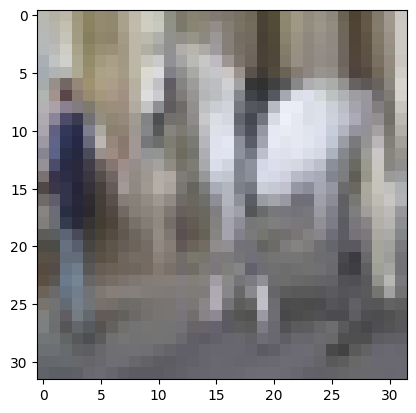

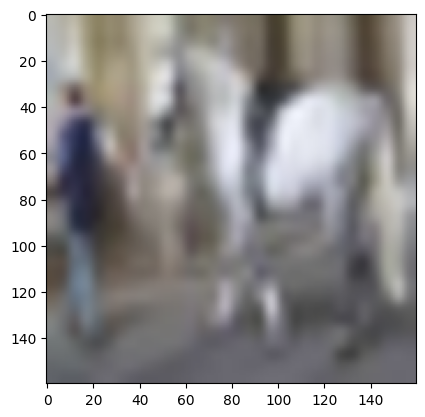

(32, 32, 3) (160, 160, 3)


In [9]:
def resize_image(image, shape=None):
    img = Image.fromarray(image)
    if shape is not None:
        img = img.resize(shape)
    image1 = np.asarray(img)
    return image1

def resize_images(images, shape=None):
    images1 = [resize_image(image, shape) for image in images]
    images1 = np.array(images1)
    return images1

input_shape=(160, 160) 
images = train_images[0:10]
images1 = resize_images(images, input_shape)

image_array = images[0]
plt.imshow(image_array)
plt.show()
 
image_array1 = images1[0]
plt.imshow(image_array1)
plt.show()

print(image_array.shape, image_array1.shape) 
# np.testing.assert_array_almost_equal(image_array, image_array1)

In [10]:
# train_images = resize_images(train_images, input_shape)
# test_images = resize_images(test_images, input_shape)

# print(train_images.shape, type(train_images), train_images.dtype)
# print(test_images.shape, type(test_images), test_images.dtype) 



### Data Explore 

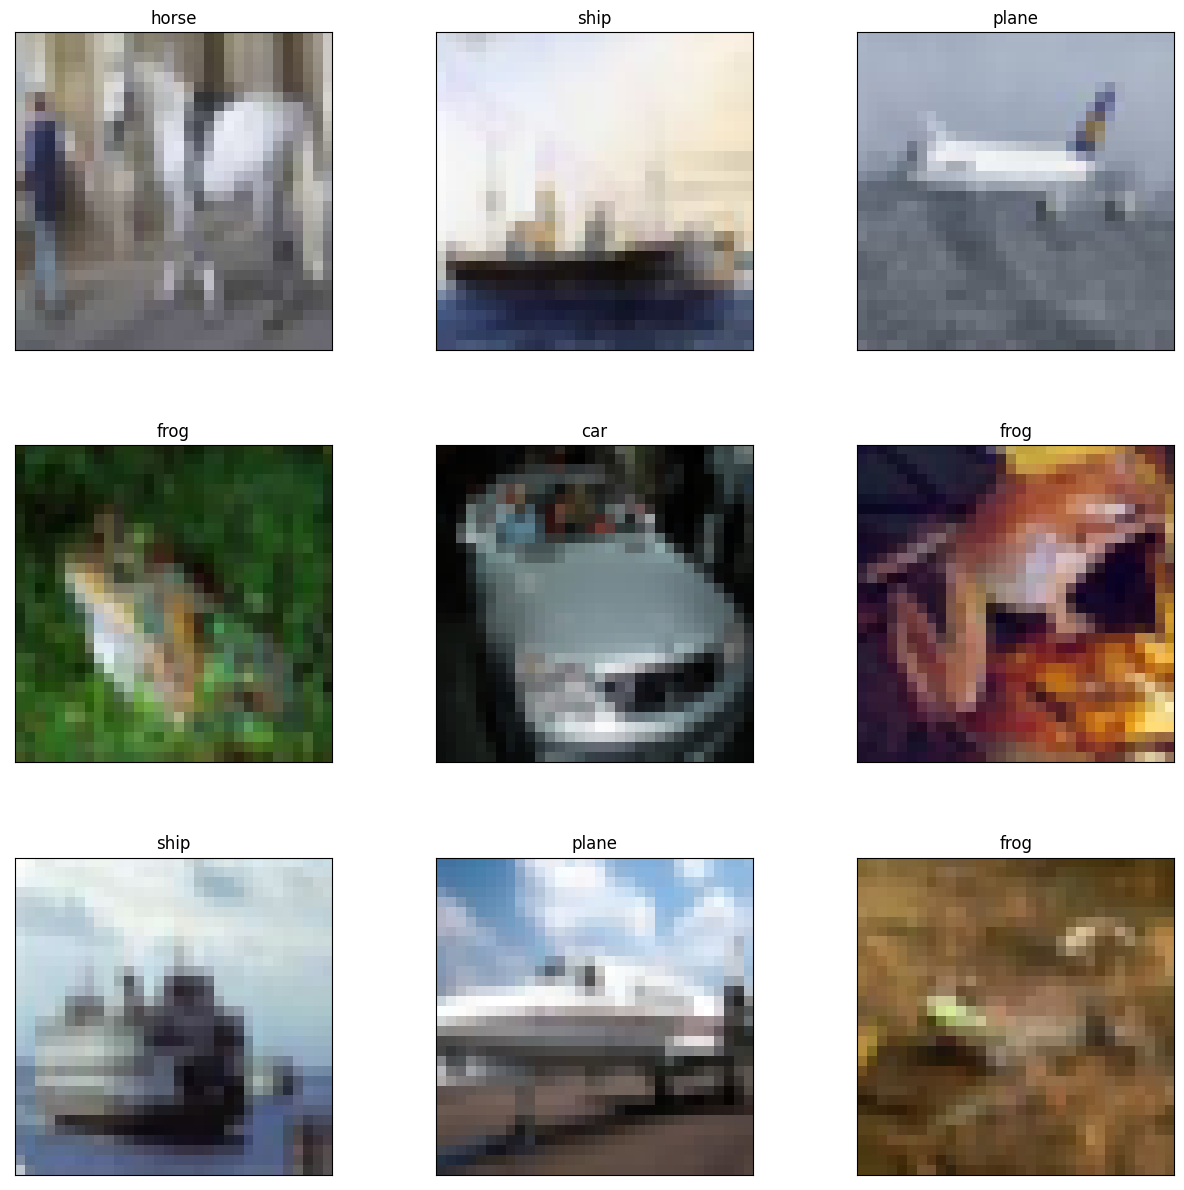

In [11]:
qtf.utils.show_images(train_images, train_labels, classes=params.classes, x_num=3, y_num=3, figsize=(12, 12))

### Class Distribution

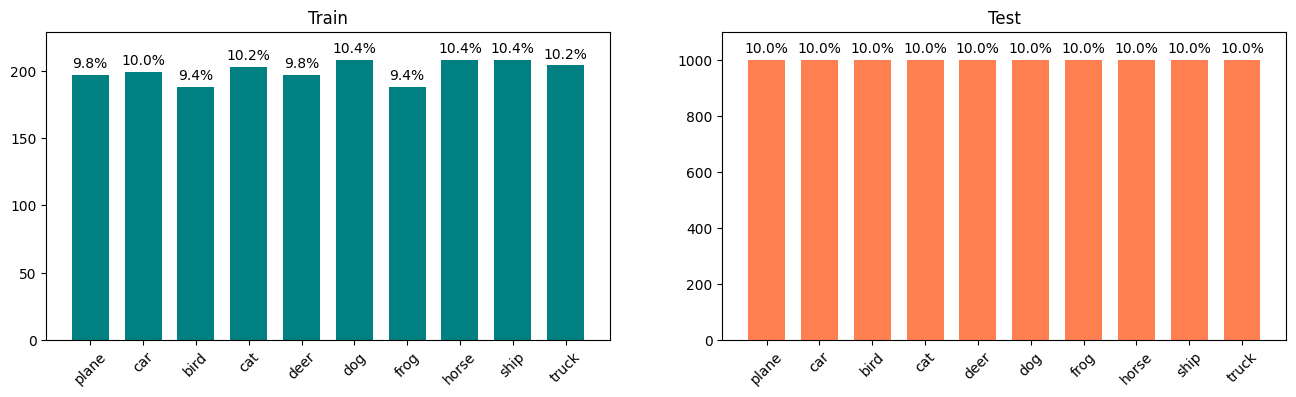

In [12]:
qtf.utils.plot_distribution(train_labels, test_labels, params.classes)



## Prepare Data


### Raw Data


In [13]:
raw_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, batch_size=params.batch_size)

In [14]:
sample_images, sample_labels = iter(raw_datasets.train_dataset).next()

In [15]:
raw_datasets.train_dataset.element_spec

(TensorSpec(shape=(32, 32, 32, 3), dtype=tf.uint8, name=None),
 TensorSpec(shape=(32,), dtype=tf.uint8, name=None))

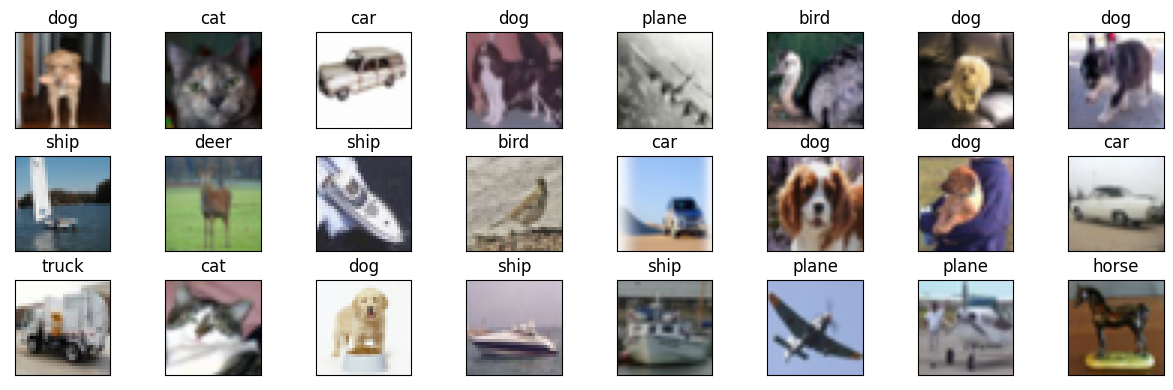

In [16]:
qtf.utils.show_images(sample_images.numpy(), sample_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4))

### Data Augmentation

In [17]:
data_generator.fit(train_images)
generator = {'train':qtf.classification.AugmentGenerator('augment', data_generator), 
             'val_test':qtf.classification.DatasetGenerator('val_test')}
augment_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, 
                                               generator=generator, batch_size=params.batch_size, 
                                               use_shuffle=False)

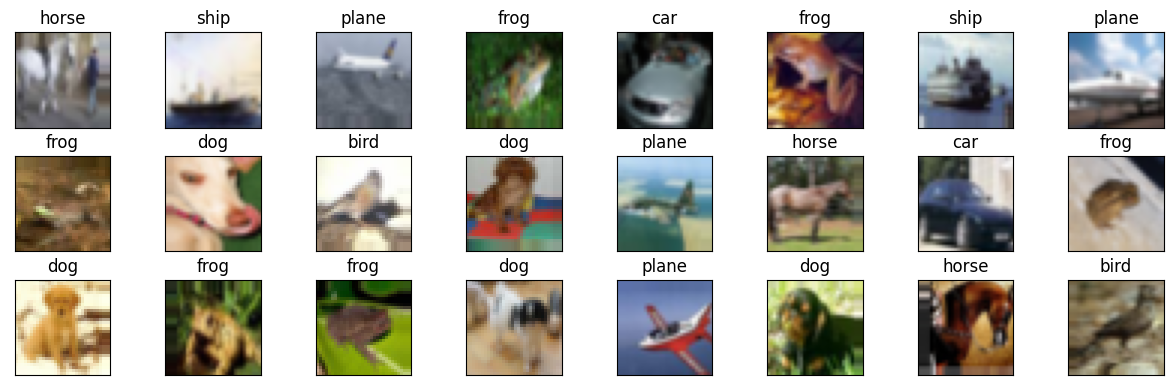

In [18]:
images, labels = iter(augment_datasets.train_dataset).next() 
qtf.utils.show_images(images, labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 

see orgin images

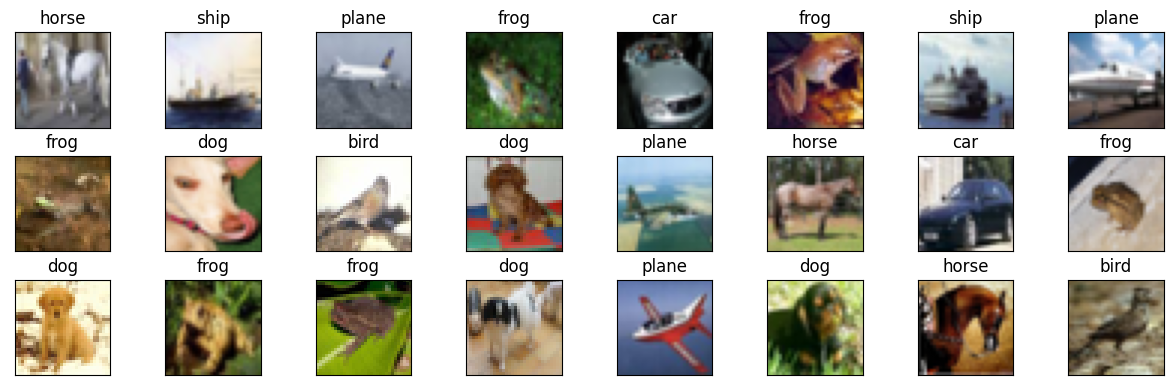

In [19]:
qtf.utils.show_images(train_images, train_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 

create data augment dataset

In [20]:
augment_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, 
                                               generator=generator, batch_size=params.batch_size, 
                                               use_shuffle=True)

In [21]:
print(f'use_data_augmentation = {params.use_data_augmentation}')
if params.use_data_augmentation:
    datasets = augment_datasets
else:
    datasets = raw_datasets

use_data_augmentation = False


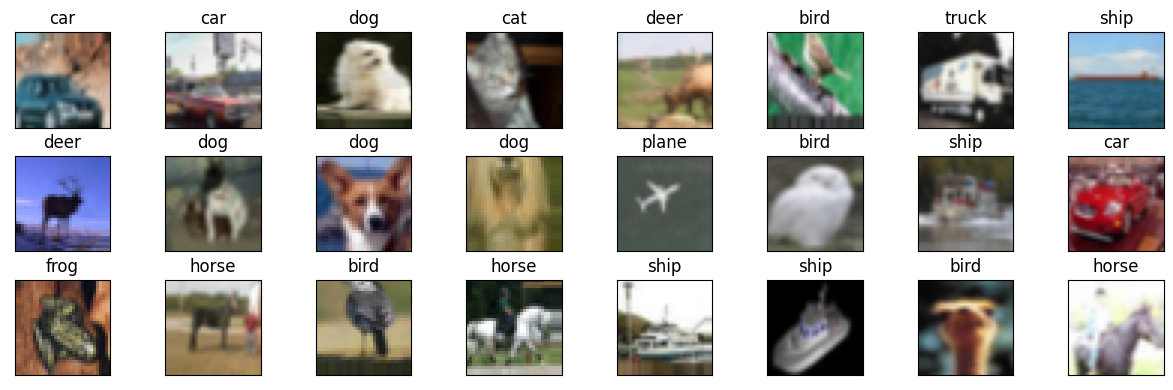

In [22]:
images, labels = iter(augment_datasets.train_dataset).next() 
qtf.utils.show_images(images, labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 



##  Models



In [22]:
rescale = tf.keras.layers.Rescaling(1./255.0, offset=0)

### MLP

2022-08-16 08:56:36,287: INFO: model_params.mlp1.dropout=0.1
2022-08-16 08:56:36,288: INFO: model_params.mlp1.layer_count=1
2022-08-16 08:56:36,289: INFO: model_params.mlp1.units=128
2022-08-16 08:56:36,331: INFO: learning_rate=0.001
2022-08-16 08:56:36,332: INFO: model_params.mlp1.clip_value=None
2022-08-16 08:56:36,342: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/mlp1


Model: "mlp1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 128)               393344    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 394,634
Trainable params: 394,634
Non-trainable 

2022-08-16 08:56:36,356: INFO: model_params.mlp1.epochs=90
2022-08-16 08:56:36,356: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/mlp1, monitor=val_accuracy)
2022-08-16 08:56:36,357: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-08-16 08:56:36,357: INFO: use LearningRateScheduler()
2022-08-16 08:56:36,358: INFO: steps_per_epoch=62
2022-08-16 08:56:36,359: INFO: start training
2022-08-16 08:56:36,359: INFO: use_class_weight=False


Epoch 1/90
43/62 [===================>..........] - ETA: 0s - loss: 2.4276 - accuracy: 0.1570INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/mlp1/assets


2022-08-16 08:56:39,036: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/mlp1/assets


62/62 [==============================] - 3s 30ms/step - loss: 2.3546 - accuracy: 0.1668 - val_loss: 2.1764 - val_accuracy: 0.1839 - lr: 0.0010
Epoch 2/90
44/62 [====================>.........] - ETA: 0s - loss: 2.1354 - accuracy: 0.1989INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/mlp1/assets


2022-08-16 08:56:40,455: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/mlp1/assets


62/62 [==============================] - 1s 23ms/step - loss: 2.1309 - accuracy: 0.1976 - val_loss: 2.1297 - val_accuracy: 0.2260 - lr: 0.0010
Epoch 3/90
44/62 [====================>.........] - ETA: 0s - loss: 2.0602 - accuracy: 0.2521INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/mlp1/assets


2022-08-16 08:56:41,891: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/mlp1/assets


62/62 [==============================] - 1s 23ms/step - loss: 2.0584 - accuracy: 0.2445 - val_loss: 2.0620 - val_accuracy: 0.2481 - lr: 0.0010
Epoch 4/90
62/62 [==============================] - 1s 12ms/step - loss: 2.0321 - accuracy: 0.2550 - val_loss: 2.0494 - val_accuracy: 0.2433 - lr: 0.0010
Epoch 5/90
45/62 [====================>.........] - ETA: 0s - loss: 1.9951 - accuracy: 0.2604INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/mlp1/assets


2022-08-16 08:56:44,128: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/mlp1/assets


62/62 [==============================] - 1s 24ms/step - loss: 1.9873 - accuracy: 0.2606 - val_loss: 1.9628 - val_accuracy: 0.2859 - lr: 0.0010
Epoch 6/90
44/62 [====================>.........] - ETA: 0s - loss: 1.9456 - accuracy: 0.2727INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/mlp1/assets


2022-08-16 08:56:45,653: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/mlp1/assets


62/62 [==============================] - 2s 25ms/step - loss: 1.9412 - accuracy: 0.2797 - val_loss: 1.9515 - val_accuracy: 0.2874 - lr: 0.0010
Epoch 7/90
45/62 [====================>.........] - ETA: 0s - loss: 1.8979 - accuracy: 0.3174INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/mlp1/assets


2022-08-16 08:56:47,025: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/mlp1/assets


62/62 [==============================] - 1s 22ms/step - loss: 1.8992 - accuracy: 0.3130 - val_loss: 1.9362 - val_accuracy: 0.2916 - lr: 0.0010
Epoch 8/90
47/62 [=====================>........] - ETA: 0s - loss: 1.8934 - accuracy: 0.3178INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/mlp1/assets


2022-08-16 08:56:48,580: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/mlp1/assets


62/62 [==============================] - 2s 25ms/step - loss: 1.8933 - accuracy: 0.3145 - val_loss: 1.9171 - val_accuracy: 0.3022 - lr: 0.0010
Epoch 9/90
62/62 [==============================] - 1s 11ms/step - loss: 1.8522 - accuracy: 0.3281 - val_loss: 1.9179 - val_accuracy: 0.2990 - lr: 0.0010
Epoch 10/90
48/62 [======================>.......] - ETA: 0s - loss: 1.8351 - accuracy: 0.3301INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/mlp1/assets


2022-08-16 08:56:50,677: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/mlp1/assets


62/62 [==============================] - 1s 23ms/step - loss: 1.8341 - accuracy: 0.3266 - val_loss: 1.8930 - val_accuracy: 0.3178 - lr: 0.0010
Epoch 11/90
62/62 [==============================] - 1s 12ms/step - loss: 1.8313 - accuracy: 0.3372 - val_loss: 1.9102 - val_accuracy: 0.3066 - lr: 0.0010
Epoch 12/90
62/62 [==============================] - 1s 11ms/step - loss: 1.8002 - accuracy: 0.3438 - val_loss: 1.9106 - val_accuracy: 0.3019 - lr: 0.0010
Epoch 13/90
62/62 [==============================] - 1s 11ms/step - loss: 1.7905 - accuracy: 0.3488 - val_loss: 1.8970 - val_accuracy: 0.3106 - lr: 0.0010
Epoch 14/90
62/62 [==============================] - 1s 11ms/step - loss: 1.7689 - accuracy: 0.3528 - val_loss: 1.9083 - val_accuracy: 0.3076 - lr: 0.0010
Epoch 15/90
62/62 [==============================] - 1s 11ms/step - loss: 1.7600 - accuracy: 0.3589 - val_loss: 1.8886 - val_accuracy: 0.3108 - lr: 0.0010
Epoch 16/90
47/62 [=====================>........] - ETA: 0s - loss: 1.7346 - accu

2022-08-16 08:56:55,576: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/mlp1/assets


62/62 [==============================] - 1s 23ms/step - loss: 1.7396 - accuracy: 0.3649 - val_loss: 1.8805 - val_accuracy: 0.3184 - lr: 0.0010
Epoch 17/90
46/62 [=====================>........] - ETA: 0s - loss: 1.7291 - accuracy: 0.3689INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/mlp1/assets


2022-08-16 08:56:56,989: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/mlp1/assets


62/62 [==============================] - 1s 23ms/step - loss: 1.7274 - accuracy: 0.3654 - val_loss: 1.8642 - val_accuracy: 0.3276 - lr: 0.0010
Epoch 18/90
43/62 [===================>..........] - ETA: 0s - loss: 1.7275 - accuracy: 0.3612INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/mlp1/assets


2022-08-16 08:56:58,466: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/mlp1/assets


62/62 [==============================] - 1s 24ms/step - loss: 1.7202 - accuracy: 0.3664 - val_loss: 1.8555 - val_accuracy: 0.3386 - lr: 0.0010
Epoch 19/90
62/62 [==============================] - 1s 13ms/step - loss: 1.7213 - accuracy: 0.3810 - val_loss: 1.8637 - val_accuracy: 0.3290 - lr: 0.0010
Epoch 20/90
62/62 [==============================] - 1s 13ms/step - loss: 1.7096 - accuracy: 0.3911 - val_loss: 1.8677 - val_accuracy: 0.3308 - lr: 0.0010
Epoch 21/90
62/62 [==============================] - 1s 13ms/step - loss: 1.6946 - accuracy: 0.3780 - val_loss: 1.8751 - val_accuracy: 0.3320 - lr: 0.0010
Epoch 22/90
62/62 [==============================] - 1s 13ms/step - loss: 1.6700 - accuracy: 0.3856 - val_loss: 1.8566 - val_accuracy: 0.3363 - lr: 0.0010
Epoch 23/90
62/62 [==============================] - 1s 13ms/step - loss: 1.6740 - accuracy: 0.4068 - val_loss: 1.8821 - val_accuracy: 0.3268 - lr: 0.0010
Epoch 24/90
44/62 [====================>.........] - ETA: 0s - loss: 1.6682 - accu

2022-08-16 08:57:03,897: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/mlp1/assets


62/62 [==============================] - 1s 24ms/step - loss: 1.6583 - accuracy: 0.4037 - val_loss: 1.8654 - val_accuracy: 0.3387 - lr: 0.0010
Epoch 25/90
62/62 [==============================] - 1s 12ms/step - loss: 1.6618 - accuracy: 0.4138 - val_loss: 1.8852 - val_accuracy: 0.3311 - lr: 0.0010
Epoch 26/90
60/62 [============================>.] - ETA: 0s - loss: 1.6639 - accuracy: 0.4052INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/mlp1/assets


2022-08-16 08:57:06,181: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/mlp1/assets


62/62 [==============================] - 2s 25ms/step - loss: 1.6602 - accuracy: 0.4062 - val_loss: 1.8590 - val_accuracy: 0.3445 - lr: 0.0010
Epoch 27/90
62/62 [==============================] - 1s 13ms/step - loss: 1.6138 - accuracy: 0.4143 - val_loss: 1.8857 - val_accuracy: 0.3330 - lr: 0.0010
Epoch 28/90
62/62 [==============================] - 1s 13ms/step - loss: 1.6150 - accuracy: 0.4178 - val_loss: 1.8800 - val_accuracy: 0.3342 - lr: 0.0010
Epoch 29/90
62/62 [==============================] - 1s 13ms/step - loss: 1.6140 - accuracy: 0.4244 - val_loss: 1.8646 - val_accuracy: 0.3408 - lr: 0.0010
Epoch 30/90
62/62 [==============================] - 1s 12ms/step - loss: 1.6131 - accuracy: 0.4294 - val_loss: 1.8830 - val_accuracy: 0.3379 - lr: 0.0010
Epoch 31/90
62/62 [==============================] - 1s 13ms/step - loss: 1.5949 - accuracy: 0.4214 - val_loss: 1.8854 - val_accuracy: 0.3323 - lr: 0.0010
Epoch 32/90
62/62 [==============================] - 1s 13ms/step - loss: 1.5819 -

2022-08-16 08:57:12,613: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/mlp1/assets



Epoch 33: ReduceLROnPlateau reducing learning rate to 0.00031622778103685084.
62/62 [==============================] - 2s 28ms/step - loss: 1.5933 - accuracy: 0.4309 - val_loss: 1.8585 - val_accuracy: 0.3463 - lr: 3.1623e-04
Epoch 00034: Still keep learning rate 0.0003162 instead of 0.001
Epoch 34/90
62/62 [==============================] - 1s 13ms/step - loss: 1.5532 - accuracy: 0.4410 - val_loss: 1.8788 - val_accuracy: 0.3409 - lr: 3.1623e-04
Epoch 00035: Still keep learning rate 0.0003162 instead of 0.001
Epoch 35/90
62/62 [==============================] - 1s 13ms/step - loss: 1.5660 - accuracy: 0.4405 - val_loss: 1.8680 - val_accuracy: 0.3434 - lr: 3.1623e-04
Epoch 00036: Still keep learning rate 0.0003162 instead of 0.001
Epoch 36/90
62/62 [==============================] - 1s 13ms/step - loss: 1.5573 - accuracy: 0.4451 - val_loss: 1.8857 - val_accuracy: 0.3370 - lr: 3.1623e-04
Epoch 00037: Still keep learning rate 0.0003162 instead of 0.001
Epoch 37/90
62/62 [==================

62/62 [==============================] - 1s 11ms/step - loss: 1.4388 - accuracy: 0.5005 - val_loss: 1.8637 - val_accuracy: 0.3439 - lr: 3.1623e-05
Epoch 00070: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 70/90
62/62 [==============================] - 1s 11ms/step - loss: 1.4616 - accuracy: 0.4738 - val_loss: 1.8642 - val_accuracy: 0.3426 - lr: 3.1623e-05
Epoch 00071: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 71/90
62/62 [==============================] - 1s 11ms/step - loss: 1.4529 - accuracy: 0.4874 - val_loss: 1.8657 - val_accuracy: 0.3443 - lr: 3.1623e-05
Epoch 00072: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 72/90
62/62 [==============================] - 1s 12ms/step - loss: 1.4532 - accuracy: 0.4914 - val_loss: 1.8651 - val_accuracy: 0.3430 - lr: 3.1623e-05
Epoch 00073: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 73/90
62/62 [==============================] - 1s 12ms/step - loss: 1.4448 - accuracy: 0.4889 - val_loss: 1.86

2022-08-16 08:57:56,905: INFO: finish training [elapsed time: 80.55 seconds]


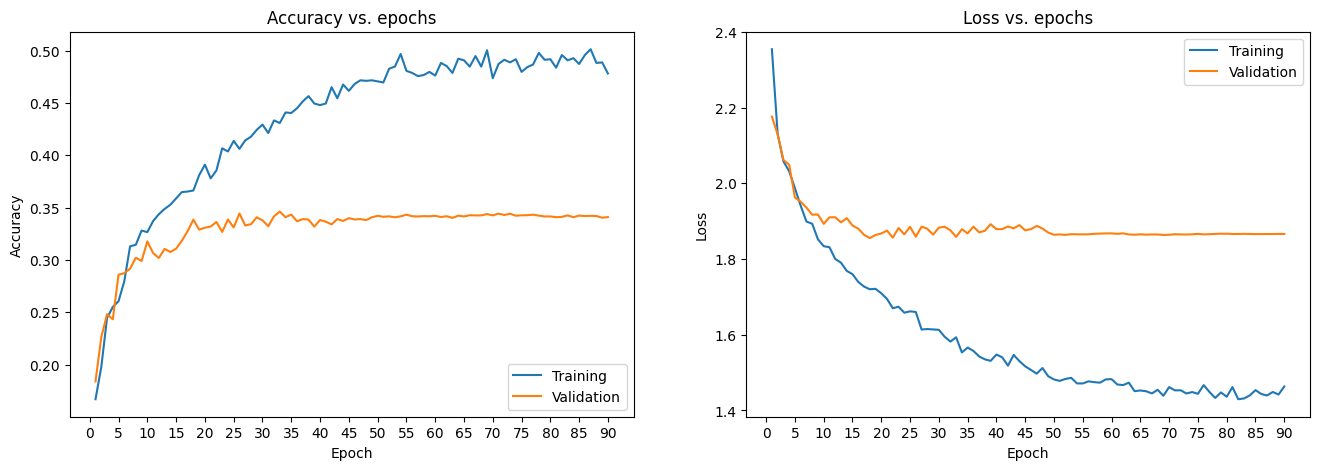

2022-08-16 08:57:57,356: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/mlp1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/mlp1
----------------------------------------evaluate----------------------------------------
313/313 [==============================] - 0s 1ms/step


2022-08-16 08:58:00,156: INFO: test loss:1.8585
2022-08-16 08:58:00,157: INFO: test accuracy:0.3463
2022-08-16 08:58:00,158: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/results.json
2022-08-16 08:58:00,160: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/results.json
2022-08-16 08:58:00,161: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/default.generator
2022-08-16 08:58:00,162: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/default.generator


----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------
313/313 [==============================] - 0s 1ms/step


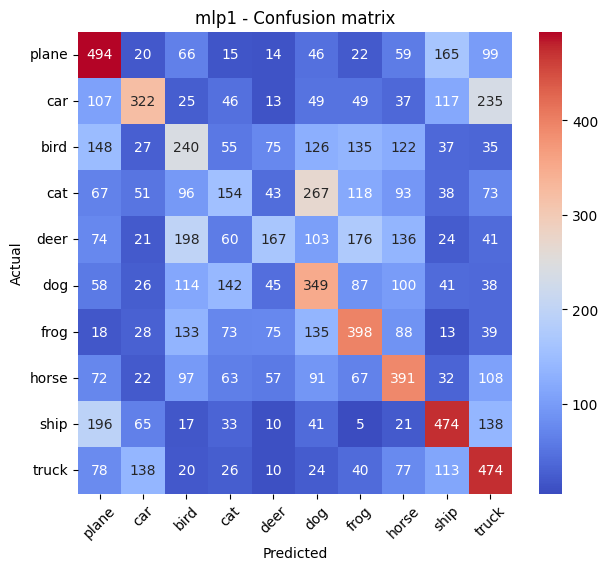

----------------------------------------models----------------------------------------


,model_name,program_name,weight_number,train_time,create_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc
1,mlp1,cifar10_0816_cnt_200.ipynb,394634,80.5,2022-08-16 08:58,1.4637,1.8585,0.5035,0.3463,0.8789,0.7867


In [23]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.mlp1(helper, name='mlp1', preprocess_fun=rescale)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=False) 




### LeNet

![image-20201019113632136](images/image-20201019113632136.png)


2022-08-16 08:58:01,700: INFO: model_params.lenet1.dropout=0.2
2022-08-16 08:58:01,813: INFO: learning_rate=0.001
2022-08-16 08:58:01,814: INFO: model_params.lenet1.clip_value=None
2022-08-16 08:58:01,822: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/lenet1


Model: "lenet1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 6)         456       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 6)        24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 6)        0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 6)         0    

2022-08-16 08:58:01,860: INFO: model_params.lenet1.epochs=90
2022-08-16 08:58:01,861: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/lenet1, monitor=val_accuracy)
2022-08-16 08:58:01,862: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-08-16 08:58:01,862: INFO: use LearningRateScheduler()
2022-08-16 08:58:01,863: INFO: steps_per_epoch=62
2022-08-16 08:58:01,863: INFO: start training
2022-08-16 08:58:01,864: INFO: use_class_weight=False


Epoch 1/90
58/62 [===========================>..] - ETA: 0s - loss: 2.3677 - accuracy: 0.1730

2022-08-16 08:58:06,358: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/lenet1/assets


2022-08-16 08:58:06,965: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/lenet1/assets


62/62 [==============================] - 5s 55ms/step - loss: 2.3555 - accuracy: 0.1714 - val_loss: 2.2433 - val_accuracy: 0.1989 - lr: 0.0010
Epoch 2/90
62/62 [==============================] - 1s 18ms/step - loss: 2.0238 - accuracy: 0.2409 - val_loss: 2.1444 - val_accuracy: 0.1812 - lr: 0.0010
Epoch 3/90
61/62 [============================>.] - ETA: 0s - loss: 1.8964 - accuracy: 0.2976

2022-08-16 08:58:10,584: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/lenet1/assets


2022-08-16 08:58:11,216: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/lenet1/assets


62/62 [==============================] - 3s 52ms/step - loss: 1.8966 - accuracy: 0.2974 - val_loss: 2.0325 - val_accuracy: 0.2220 - lr: 0.0010
Epoch 4/90
51/62 [=======================>......] - ETA: 0s - loss: 1.8132 - accuracy: 0.3511

2022-08-16 08:58:13,934: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/lenet1/assets


2022-08-16 08:58:14,608: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/lenet1/assets


62/62 [==============================] - 3s 55ms/step - loss: 1.8199 - accuracy: 0.3438 - val_loss: 1.9252 - val_accuracy: 0.2826 - lr: 0.0010
Epoch 5/90
60/62 [============================>.] - ETA: 0s - loss: 1.7209 - accuracy: 0.3828

2022-08-16 08:58:17,069: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/lenet1/assets


2022-08-16 08:58:17,702: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/lenet1/assets


62/62 [==============================] - 3s 50ms/step - loss: 1.7184 - accuracy: 0.3831 - val_loss: 1.8012 - val_accuracy: 0.3461 - lr: 0.0010
Epoch 6/90
60/62 [============================>.] - ETA: 0s - loss: 1.6733 - accuracy: 0.3896

2022-08-16 08:58:20,384: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/lenet1/assets


2022-08-16 08:58:21,023: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/lenet1/assets


62/62 [==============================] - 3s 54ms/step - loss: 1.6687 - accuracy: 0.3926 - val_loss: 1.7733 - val_accuracy: 0.3549 - lr: 0.0010
Epoch 7/90
57/62 [==========================>...] - ETA: 0s - loss: 1.6044 - accuracy: 0.4254

2022-08-16 08:58:23,511: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/lenet1/assets


2022-08-16 08:58:24,183: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/lenet1/assets


62/62 [==============================] - 3s 52ms/step - loss: 1.6023 - accuracy: 0.4274 - val_loss: 1.7440 - val_accuracy: 0.3864 - lr: 0.0010
Epoch 8/90
62/62 [==============================] - 1s 19ms/step - loss: 1.5756 - accuracy: 0.4400 - val_loss: 1.8065 - val_accuracy: 0.3645 - lr: 0.0010
Epoch 9/90
62/62 [==============================] - 1s 16ms/step - loss: 1.5092 - accuracy: 0.4688 - val_loss: 1.8159 - val_accuracy: 0.3707 - lr: 0.0010
Epoch 10/90
52/62 [========================>.....] - ETA: 0s - loss: 1.4286 - accuracy: 0.4826

2022-08-16 08:58:28,753: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/lenet1/assets


2022-08-16 08:58:29,441: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/lenet1/assets


62/62 [==============================] - 3s 50ms/step - loss: 1.4160 - accuracy: 0.4869 - val_loss: 1.7702 - val_accuracy: 0.3889 - lr: 0.0010
Epoch 11/90
62/62 [==============================] - 1s 16ms/step - loss: 1.3993 - accuracy: 0.4950 - val_loss: 1.8345 - val_accuracy: 0.3768 - lr: 0.0010
Epoch 12/90
62/62 [==============================] - ETA: 0s - loss: 1.3407 - accuracy: 0.5227

2022-08-16 08:58:33,007: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/lenet1/assets


2022-08-16 08:58:33,625: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/lenet1/assets


62/62 [==============================] - 3s 52ms/step - loss: 1.3407 - accuracy: 0.5227 - val_loss: 1.6302 - val_accuracy: 0.4260 - lr: 0.0010
Epoch 13/90
60/62 [============================>.] - ETA: 0s - loss: 1.2627 - accuracy: 0.5349

2022-08-16 08:58:35,979: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/lenet1/assets


2022-08-16 08:58:36,589: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/lenet1/assets


62/62 [==============================] - 3s 48ms/step - loss: 1.2586 - accuracy: 0.5358 - val_loss: 1.6379 - val_accuracy: 0.4355 - lr: 0.0010
Epoch 14/90
58/62 [===========================>..] - ETA: 0s - loss: 1.2084 - accuracy: 0.5668

2022-08-16 08:58:39,103: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/lenet1/assets


2022-08-16 08:58:39,716: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/lenet1/assets


62/62 [==============================] - 3s 51ms/step - loss: 1.2087 - accuracy: 0.5685 - val_loss: 1.6137 - val_accuracy: 0.4466 - lr: 0.0010
Epoch 15/90
62/62 [==============================] - 1s 17ms/step - loss: 1.1770 - accuracy: 0.5781 - val_loss: 1.7487 - val_accuracy: 0.4108 - lr: 0.0010
Epoch 16/90
62/62 [==============================] - 1s 19ms/step - loss: 1.1130 - accuracy: 0.5917 - val_loss: 1.6995 - val_accuracy: 0.4462 - lr: 0.0010
Epoch 17/90
54/62 [=========================>....] - ETA: 0s - loss: 1.0591 - accuracy: 0.6117

2022-08-16 08:58:44,644: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/lenet1/assets


2022-08-16 08:58:45,275: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/lenet1/assets


62/62 [==============================] - 3s 54ms/step - loss: 1.0652 - accuracy: 0.6074 - val_loss: 1.6335 - val_accuracy: 0.4609 - lr: 0.0010
Epoch 18/90
62/62 [==============================] - 1s 16ms/step - loss: 1.0400 - accuracy: 0.6346 - val_loss: 1.8486 - val_accuracy: 0.4313 - lr: 0.0010
Epoch 19/90
62/62 [==============================] - 1s 16ms/step - loss: 1.0190 - accuracy: 0.6255 - val_loss: 2.0519 - val_accuracy: 0.3852 - lr: 0.0010
Epoch 20/90
62/62 [==============================] - 1s 17ms/step - loss: 0.9812 - accuracy: 0.6381 - val_loss: 2.4487 - val_accuracy: 0.3568 - lr: 0.0010
Epoch 21/90
62/62 [==============================] - 1s 17ms/step - loss: 0.9414 - accuracy: 0.6633 - val_loss: 1.8003 - val_accuracy: 0.4413 - lr: 0.0010
Epoch 22/90
62/62 [==============================] - 1s 18ms/step - loss: 0.8529 - accuracy: 0.6956 - val_loss: 1.7909 - val_accuracy: 0.4498 - lr: 0.0010
Epoch 23/90
62/62 [==============================] - 1s 15ms/step - loss: 0.8367 -

2022-08-16 08:59:00,249: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/lenet1/assets


2022-08-16 08:59:00,863: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/lenet1/assets


62/62 [==============================] - 3s 52ms/step - loss: 0.5993 - accuracy: 0.7838 - val_loss: 1.8385 - val_accuracy: 0.4644 - lr: 3.1623e-04
Epoch 00031: Still keep learning rate 0.0003162 instead of 0.001
Epoch 31/90
62/62 [==============================] - 1s 19ms/step - loss: 0.5829 - accuracy: 0.7903 - val_loss: 1.8494 - val_accuracy: 0.4587 - lr: 3.1623e-04
Epoch 00032: Still keep learning rate 0.0003162 instead of 0.001
Epoch 32/90
62/62 [==============================] - 1s 19ms/step - loss: 0.5692 - accuracy: 0.7994 - val_loss: 2.0408 - val_accuracy: 0.4552 - lr: 3.1623e-04
Epoch 00033: Still keep learning rate 0.0003162 instead of 0.001
Epoch 33/90
62/62 [==============================] - 1s 19ms/step - loss: 0.5684 - accuracy: 0.7984 - val_loss: 1.9088 - val_accuracy: 0.4637 - lr: 3.1623e-04
Epoch 00034: Still keep learning rate 0.0003162 instead of 0.001
Epoch 34/90
56/62 [==========================>...] - ETA: 0s - loss: 0.5074 - accuracy: 0.8309

2022-08-16 08:59:06,859: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/lenet1/assets


2022-08-16 08:59:07,473: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/lenet1/assets


62/62 [==============================] - 3s 50ms/step - loss: 0.5034 - accuracy: 0.8301 - val_loss: 1.8878 - val_accuracy: 0.4671 - lr: 3.1623e-04
Epoch 00035: Still keep learning rate 0.0003162 instead of 0.001
Epoch 35/90
59/62 [===========================>..] - ETA: 0s - loss: 0.5228 - accuracy: 0.8247

2022-08-16 08:59:10,198: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/lenet1/assets


2022-08-16 08:59:10,903: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/lenet1/assets


62/62 [==============================] - 3s 56ms/step - loss: 0.5196 - accuracy: 0.8266 - val_loss: 1.9586 - val_accuracy: 0.4698 - lr: 3.1623e-04
Epoch 00036: Still keep learning rate 0.0003162 instead of 0.001
Epoch 36/90
62/62 [==============================] - 1s 18ms/step - loss: 0.5085 - accuracy: 0.8236 - val_loss: 2.0204 - val_accuracy: 0.4620 - lr: 3.1623e-04
Epoch 00037: Still keep learning rate 0.0003162 instead of 0.001
Epoch 37/90
62/62 [==============================] - 1s 20ms/step - loss: 0.4749 - accuracy: 0.8337 - val_loss: 2.0101 - val_accuracy: 0.4565 - lr: 3.1623e-04
Epoch 00038: Still keep learning rate 0.0003162 instead of 0.001
Epoch 38/90
62/62 [==============================] - 1s 19ms/step - loss: 0.5060 - accuracy: 0.8221 - val_loss: 1.9582 - val_accuracy: 0.4679 - lr: 3.1623e-04
Epoch 00039: Still keep learning rate 0.0003162 instead of 0.001
Epoch 39/90
62/62 [==============================] - 1s 18ms/step - loss: 0.4843 - accuracy: 0.8271 - val_loss: 2.02

2022-08-16 08:59:23,985: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/lenet1/assets


2022-08-16 08:59:24,600: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/lenet1/assets


62/62 [==============================] - 3s 52ms/step - loss: 0.4203 - accuracy: 0.8503 - val_loss: 1.9374 - val_accuracy: 0.4751 - lr: 1.0000e-04
Epoch 00046: Still keep learning rate 0.0001 instead of 0.001
Epoch 46/90
62/62 [==============================] - 1s 18ms/step - loss: 0.4288 - accuracy: 0.8553 - val_loss: 1.9816 - val_accuracy: 0.4732 - lr: 1.0000e-04
Epoch 00047: Still keep learning rate 0.0001 instead of 0.001
Epoch 47/90
62/62 [==============================] - ETA: 0s - loss: 0.4162 - accuracy: 0.8548

2022-08-16 08:59:28,228: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/lenet1/assets


2022-08-16 08:59:28,847: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/lenet1/assets


62/62 [==============================] - 3s 52ms/step - loss: 0.4162 - accuracy: 0.8548 - val_loss: 1.9494 - val_accuracy: 0.4753 - lr: 1.0000e-04
Epoch 00048: Still keep learning rate 0.0001 instead of 0.001
Epoch 48/90
62/62 [==============================] - 1s 16ms/step - loss: 0.3890 - accuracy: 0.8720 - val_loss: 2.0050 - val_accuracy: 0.4748 - lr: 1.0000e-04
Epoch 00049: Still keep learning rate 0.0001 instead of 0.001
Epoch 49/90
62/62 [==============================] - 1s 18ms/step - loss: 0.4063 - accuracy: 0.8533 - val_loss: 1.9915 - val_accuracy: 0.4743 - lr: 1.0000e-04
Epoch 00050: Still keep learning rate 0.0001 instead of 0.001
Epoch 50/90
62/62 [==============================] - ETA: 0s - loss: 0.4106 - accuracy: 0.8609

2022-08-16 08:59:33,777: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/lenet1/assets


2022-08-16 08:59:34,400: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/lenet1/assets


62/62 [==============================] - 3s 56ms/step - loss: 0.4106 - accuracy: 0.8609 - val_loss: 2.0065 - val_accuracy: 0.4768 - lr: 1.0000e-04
Epoch 00051: Still keep learning rate 0.0001 instead of 0.001
Epoch 51/90
62/62 [==============================] - 1s 19ms/step - loss: 0.4144 - accuracy: 0.8609 - val_loss: 2.0221 - val_accuracy: 0.4722 - lr: 1.0000e-04
Epoch 00052: Still keep learning rate 0.0001 instead of 0.001
Epoch 52/90
62/62 [==============================] - 1s 20ms/step - loss: 0.4305 - accuracy: 0.8513 - val_loss: 1.9841 - val_accuracy: 0.4698 - lr: 1.0000e-04
Epoch 00053: Still keep learning rate 0.0001 instead of 0.001
Epoch 53/90
62/62 [==============================] - 1s 18ms/step - loss: 0.3841 - accuracy: 0.8720 - val_loss: 2.0257 - val_accuracy: 0.4738 - lr: 1.0000e-04
Epoch 00054: Still keep learning rate 0.0001 instead of 0.001
Epoch 54/90
62/62 [==============================] - 1s 17ms/step - loss: 0.3816 - accuracy: 0.8629 - val_loss: 2.0200 - val_acc

52/62 [========================>.....] - ETA: 0s - loss: 0.3437 - accuracy: 0.8732

2022-08-16 09:00:21,028: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/lenet1/assets


2022-08-16 09:00:21,646: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/lenet1/assets



Epoch 89: ReduceLROnPlateau reducing learning rate to 9.999999259090306e-06.
62/62 [==============================] - 3s 51ms/step - loss: 0.3459 - accuracy: 0.8735 - val_loss: 2.0898 - val_accuracy: 0.4771 - lr: 1.0000e-05
Epoch 00090: Still keep learning rate 1e-05 instead of 0.0001
Epoch 90/90
58/62 [===========================>..] - ETA: 0s - loss: 0.3386 - accuracy: 0.8793

2022-08-16 09:00:24,098: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/lenet1/assets


2022-08-16 09:00:24,712: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/lenet1/assets


62/62 [==============================] - 3s 50ms/step - loss: 0.3421 - accuracy: 0.8795 - val_loss: 2.0866 - val_accuracy: 0.4772 - lr: 1.0000e-05


2022-08-16 09:00:24,786: INFO: finish training [elapsed time: 142.92 seconds]


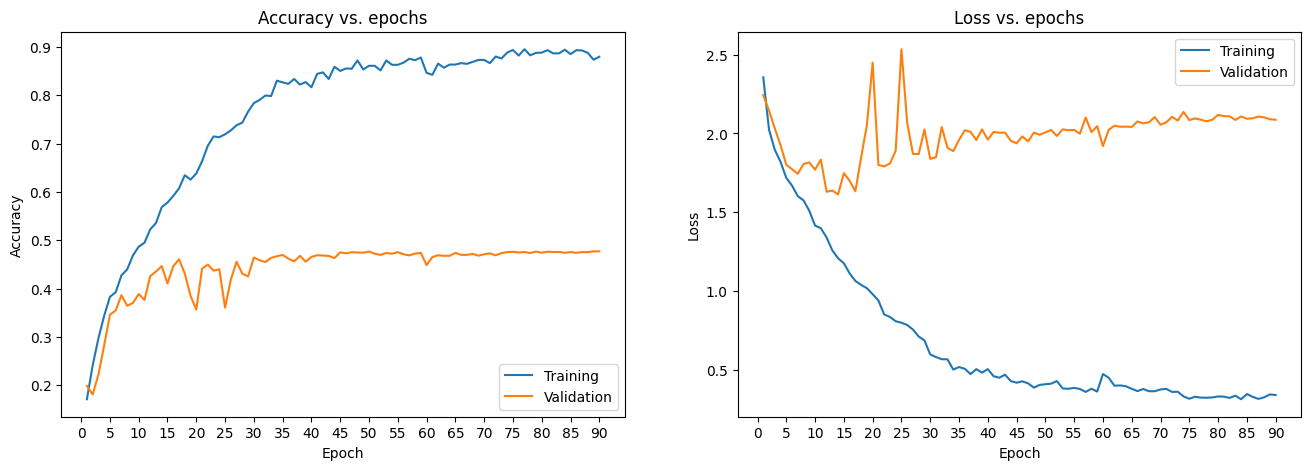

2022-08-16 09:00:25,227: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/lenet1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/lenet1
----------------------------------------evaluate----------------------------------------
313/313 [==============================] - 1s 2ms/step


2022-08-16 09:00:29,312: INFO: test loss:2.0866
2022-08-16 09:00:29,313: INFO: test accuracy:0.4772
2022-08-16 09:00:29,315: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/results.json
2022-08-16 09:00:29,318: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/results.json
2022-08-16 09:00:29,318: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/default.generator
2022-08-16 09:00:29,320: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/default.generator
2022-08-16 09:00:29,321: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/mlp1


----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-08-16 09:00:29,673: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/default.generator


313/313 [==============================] - 0s 1ms/step


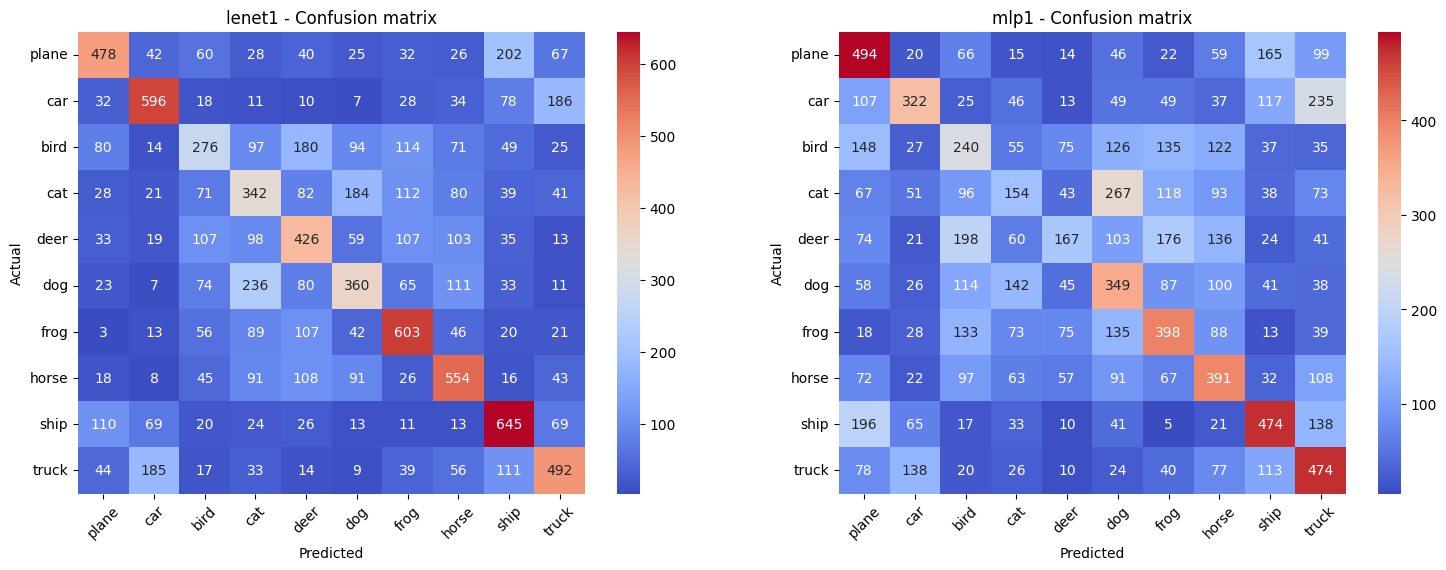

----------------------------------------models----------------------------------------


,model_name,program_name,weight_number,train_time,create_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc
1,lenet1,cifar10_0816_cnt_200.ipynb,83170,142.9,2022-08-16 09:00,0.0541,2.0866,0.9945,0.4772,0.9998,0.8650
2,mlp1,cifar10_0816_cnt_200.ipynb,394634,80.5,2022-08-16 08:58,1.4637,1.8585,0.5035,0.3463,0.8789,0.7867


In [24]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.lenet1(helper, name='lenet1', preprocess_fun=rescale)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=False) 

### Custom 1


2022-08-16 09:00:33,076: INFO: model_params.custom1.dropout=0.2
2022-08-16 09:00:33,190: INFO: learning_rate=0.001
2022-08-16 09:00:33,191: INFO: model_params.custom1.clip_value=None
2022-08-16 09:00:33,198: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/custom1


Model: "custom1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_2 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 16, 16, 32)        0   

2022-08-16 09:00:33,232: INFO: model_params.custom1.epochs=90
2022-08-16 09:00:33,232: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/custom1, monitor=val_accuracy)
2022-08-16 09:00:33,233: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-08-16 09:00:33,234: INFO: use LearningRateScheduler()
2022-08-16 09:00:33,234: INFO: steps_per_epoch=62
2022-08-16 09:00:33,235: INFO: start training
2022-08-16 09:00:33,235: INFO: use_class_weight=False


Epoch 1/90
56/62 [==========================>...] - ETA: 0s - loss: 2.4916 - accuracy: 0.1858

2022-08-16 09:00:37,403: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/custom1/assets


2022-08-16 09:00:38,105: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/custom1/assets


62/62 [==============================] - 5s 65ms/step - loss: 2.4623 - accuracy: 0.1865 - val_loss: 2.9419 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 2/90
59/62 [===========================>..] - ETA: 0s - loss: 1.9918 - accuracy: 0.2760

2022-08-16 09:00:41,339: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/custom1/assets


2022-08-16 09:00:42,044: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/custom1/assets


62/62 [==============================] - 4s 64ms/step - loss: 1.9868 - accuracy: 0.2792 - val_loss: 3.4207 - val_accuracy: 0.1196 - lr: 0.0010
Epoch 3/90
54/62 [=========================>....] - ETA: 0s - loss: 1.8833 - accuracy: 0.3137

2022-08-16 09:00:44,960: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/custom1/assets


2022-08-16 09:00:45,673: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/custom1/assets


62/62 [==============================] - 4s 59ms/step - loss: 1.8746 - accuracy: 0.3165 - val_loss: 3.7166 - val_accuracy: 0.1672 - lr: 0.0010
Epoch 4/90
62/62 [==============================] - 1s 20ms/step - loss: 1.7344 - accuracy: 0.3735 - val_loss: 3.6432 - val_accuracy: 0.1570 - lr: 0.0010
Epoch 5/90
56/62 [==========================>...] - ETA: 0s - loss: 1.6177 - accuracy: 0.4191

2022-08-16 09:00:49,871: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/custom1/assets


2022-08-16 09:00:50,852: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/custom1/assets


62/62 [==============================] - 4s 64ms/step - loss: 1.6172 - accuracy: 0.4199 - val_loss: 3.4118 - val_accuracy: 0.1938 - lr: 0.0010
Epoch 6/90
60/62 [============================>.] - ETA: 0s - loss: 1.5739 - accuracy: 0.4339

2022-08-16 09:00:53,871: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/custom1/assets


2022-08-16 09:00:54,602: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/custom1/assets


62/62 [==============================] - 4s 61ms/step - loss: 1.5748 - accuracy: 0.4330 - val_loss: 2.6612 - val_accuracy: 0.2516 - lr: 0.0010
Epoch 7/90
58/62 [===========================>..] - ETA: 0s - loss: 1.4856 - accuracy: 0.4607

2022-08-16 09:00:57,309: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/custom1/assets


2022-08-16 09:00:57,990: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/custom1/assets


62/62 [==============================] - 3s 55ms/step - loss: 1.4869 - accuracy: 0.4602 - val_loss: 2.5091 - val_accuracy: 0.2688 - lr: 0.0010
Epoch 8/90
57/62 [==========================>...] - ETA: 0s - loss: 1.4506 - accuracy: 0.4666

2022-08-16 09:01:01,063: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/custom1/assets


2022-08-16 09:01:02,056: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/custom1/assets


62/62 [==============================] - 4s 67ms/step - loss: 1.4506 - accuracy: 0.4672 - val_loss: 2.1382 - val_accuracy: 0.3081 - lr: 0.0010
Epoch 9/90
59/62 [===========================>..] - ETA: 0s - loss: 1.3759 - accuracy: 0.4894

2022-08-16 09:01:05,085: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/custom1/assets


2022-08-16 09:01:05,781: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/custom1/assets


62/62 [==============================] - 4s 61ms/step - loss: 1.3765 - accuracy: 0.4884 - val_loss: 1.9908 - val_accuracy: 0.3526 - lr: 0.0010
Epoch 10/90
58/62 [===========================>..] - ETA: 0s - loss: 1.3393 - accuracy: 0.5172

2022-08-16 09:01:08,698: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/custom1/assets


2022-08-16 09:01:09,390: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/custom1/assets


62/62 [==============================] - 4s 59ms/step - loss: 1.3402 - accuracy: 0.5176 - val_loss: 1.8112 - val_accuracy: 0.3865 - lr: 0.0010
Epoch 11/90
62/62 [==============================] - 1s 19ms/step - loss: 1.2614 - accuracy: 0.5403 - val_loss: 1.9471 - val_accuracy: 0.3802 - lr: 0.0010
Epoch 12/90
55/62 [=========================>....] - ETA: 0s - loss: 1.2357 - accuracy: 0.5466

2022-08-16 09:01:13,679: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/custom1/assets


2022-08-16 09:01:14,400: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/custom1/assets


62/62 [==============================] - 4s 63ms/step - loss: 1.2322 - accuracy: 0.5479 - val_loss: 1.5409 - val_accuracy: 0.4683 - lr: 0.0010
Epoch 13/90
62/62 [==============================] - 1s 24ms/step - loss: 1.1946 - accuracy: 0.5721 - val_loss: 1.6064 - val_accuracy: 0.4456 - lr: 0.0010
Epoch 14/90
62/62 [==============================] - 2s 25ms/step - loss: 1.1726 - accuracy: 0.5711 - val_loss: 1.8002 - val_accuracy: 0.4139 - lr: 0.0010
Epoch 15/90
62/62 [==============================] - 1s 18ms/step - loss: 1.1137 - accuracy: 0.5993 - val_loss: 1.8413 - val_accuracy: 0.4135 - lr: 0.0010
Epoch 16/90
56/62 [==========================>...] - ETA: 0s - loss: 1.0598 - accuracy: 0.6094

2022-08-16 09:01:21,329: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/custom1/assets


2022-08-16 09:01:22,035: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/custom1/assets


62/62 [==============================] - 3s 56ms/step - loss: 1.0574 - accuracy: 0.6084 - val_loss: 1.5234 - val_accuracy: 0.4891 - lr: 0.0010
Epoch 17/90
62/62 [==============================] - 1s 17ms/step - loss: 1.0593 - accuracy: 0.6053 - val_loss: 1.5641 - val_accuracy: 0.4796 - lr: 0.0010
Epoch 18/90
62/62 [==============================] - 2s 37ms/step - loss: 0.9871 - accuracy: 0.6507 - val_loss: 2.3168 - val_accuracy: 0.3804 - lr: 0.0010
Epoch 19/90
62/62 [==============================] - ETA: 0s - loss: 0.9534 - accuracy: 0.6447

2022-08-16 09:01:29,589: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/custom1/assets


2022-08-16 09:01:30,306: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/custom1/assets


62/62 [==============================] - 5s 81ms/step - loss: 0.9534 - accuracy: 0.6447 - val_loss: 1.5682 - val_accuracy: 0.4904 - lr: 0.0010
Epoch 20/90
62/62 [==============================] - 2s 35ms/step - loss: 0.9318 - accuracy: 0.6638 - val_loss: 1.6656 - val_accuracy: 0.4647 - lr: 0.0010
Epoch 21/90
62/62 [==============================] - 1s 18ms/step - loss: 0.8665 - accuracy: 0.6951 - val_loss: 1.7551 - val_accuracy: 0.4393 - lr: 0.0010
Epoch 22/90
62/62 [==============================] - 1s 18ms/step - loss: 0.8486 - accuracy: 0.6991 - val_loss: 1.6344 - val_accuracy: 0.4741 - lr: 0.0010
Epoch 23/90
59/62 [===========================>..] - ETA: 0s - loss: 0.8253 - accuracy: 0.6997

2022-08-16 09:01:37,762: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/custom1/assets


2022-08-16 09:01:38,470: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/custom1/assets


62/62 [==============================] - 4s 61ms/step - loss: 0.8206 - accuracy: 0.7006 - val_loss: 1.5610 - val_accuracy: 0.4944 - lr: 0.0010
Epoch 24/90
55/62 [=========================>....] - ETA: 0s - loss: 0.7783 - accuracy: 0.7148

2022-08-16 09:01:41,221: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/custom1/assets


2022-08-16 09:01:41,935: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/custom1/assets


62/62 [==============================] - 3s 56ms/step - loss: 0.7681 - accuracy: 0.7177 - val_loss: 1.5714 - val_accuracy: 0.5057 - lr: 0.0010
Epoch 25/90
62/62 [==============================] - 1s 19ms/step - loss: 0.7713 - accuracy: 0.7177 - val_loss: 1.5797 - val_accuracy: 0.4917 - lr: 0.0010
Epoch 26/90
62/62 [==============================] - 1s 19ms/step - loss: 0.7459 - accuracy: 0.7258 - val_loss: 1.7690 - val_accuracy: 0.4831 - lr: 0.0010
Epoch 27/90
62/62 [==============================] - 1s 19ms/step - loss: 0.6917 - accuracy: 0.7495 - val_loss: 1.6208 - val_accuracy: 0.4938 - lr: 0.0010
Epoch 28/90
62/62 [==============================] - 1s 19ms/step - loss: 0.6877 - accuracy: 0.7555 - val_loss: 1.6106 - val_accuracy: 0.4853 - lr: 0.0010
Epoch 29/90
62/62 [==============================] - 1s 19ms/step - loss: 0.6604 - accuracy: 0.7530 - val_loss: 2.1862 - val_accuracy: 0.3898 - lr: 0.0010
Epoch 30/90
62/62 [==============================] - 1s 19ms/step - loss: 0.6413 -

2022-08-16 09:01:52,774: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/custom1/assets


2022-08-16 09:01:53,763: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/custom1/assets


62/62 [==============================] - 4s 61ms/step - loss: 0.5522 - accuracy: 0.8019 - val_loss: 1.5164 - val_accuracy: 0.5224 - lr: 3.1623e-04
Epoch 00033: Still keep learning rate 0.0003162 instead of 0.001
Epoch 33/90
59/62 [===========================>..] - ETA: 0s - loss: 0.5119 - accuracy: 0.8109

2022-08-16 09:01:56,444: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/custom1/assets


2022-08-16 09:01:57,138: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/custom1/assets


62/62 [==============================] - 3s 55ms/step - loss: 0.5107 - accuracy: 0.8115 - val_loss: 1.5738 - val_accuracy: 0.5242 - lr: 3.1623e-04
Epoch 00034: Still keep learning rate 0.0003162 instead of 0.001
Epoch 34/90
54/62 [=========================>....] - ETA: 0s - loss: 0.4992 - accuracy: 0.8137

2022-08-16 09:01:59,844: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/custom1/assets


2022-08-16 09:02:00,535: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/custom1/assets


62/62 [==============================] - 3s 55ms/step - loss: 0.5006 - accuracy: 0.8155 - val_loss: 1.5708 - val_accuracy: 0.5282 - lr: 3.1623e-04
Epoch 00035: Still keep learning rate 0.0003162 instead of 0.001
Epoch 35/90
62/62 [==============================] - 1s 18ms/step - loss: 0.4756 - accuracy: 0.8362 - val_loss: 1.6096 - val_accuracy: 0.5269 - lr: 3.1623e-04
Epoch 00036: Still keep learning rate 0.0003162 instead of 0.001
Epoch 36/90
62/62 [==============================] - 1s 18ms/step - loss: 0.4657 - accuracy: 0.8306 - val_loss: 1.6303 - val_accuracy: 0.5235 - lr: 3.1623e-04
Epoch 00037: Still keep learning rate 0.0003162 instead of 0.001
Epoch 37/90
62/62 [==============================] - 1s 18ms/step - loss: 0.4656 - accuracy: 0.8362 - val_loss: 1.6008 - val_accuracy: 0.5224 - lr: 3.1623e-04
Epoch 00038: Still keep learning rate 0.0003162 instead of 0.001
Epoch 38/90
62/62 [==============================] - 1s 19ms/step - loss: 0.4515 - accuracy: 0.8458 - val_loss: 1.72

2022-08-16 09:02:10,234: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/custom1/assets


2022-08-16 09:02:10,969: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/custom1/assets


62/62 [==============================] - 4s 68ms/step - loss: 0.4176 - accuracy: 0.8584 - val_loss: 1.5946 - val_accuracy: 0.5326 - lr: 3.1623e-04
Epoch 00041: Still keep learning rate 0.0003162 instead of 0.001
Epoch 41/90
62/62 [==============================] - 1s 18ms/step - loss: 0.3899 - accuracy: 0.8674 - val_loss: 1.6443 - val_accuracy: 0.5228 - lr: 3.1623e-04
Epoch 00042: Still keep learning rate 0.0003162 instead of 0.001
Epoch 42/90
62/62 [==============================] - 2s 27ms/step - loss: 0.4203 - accuracy: 0.8498 - val_loss: 1.6520 - val_accuracy: 0.5243 - lr: 3.1623e-04
Epoch 00043: Still keep learning rate 0.0003162 instead of 0.001
Epoch 43/90
62/62 [==============================] - 2s 26ms/step - loss: 0.4321 - accuracy: 0.8488 - val_loss: 1.6722 - val_accuracy: 0.5199 - lr: 3.1623e-04
Epoch 00044: Still keep learning rate 0.0003162 instead of 0.001
Epoch 44/90
62/62 [==============================] - 1s 19ms/step - loss: 0.3849 - accuracy: 0.8695 - val_loss: 1.74

2022-08-16 09:02:26,746: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/custom1/assets


2022-08-16 09:02:27,638: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/custom1/assets


62/62 [==============================] - 4s 71ms/step - loss: 0.3325 - accuracy: 0.8816 - val_loss: 1.6659 - val_accuracy: 0.5337 - lr: 1.0000e-04
Epoch 00051: Still keep learning rate 0.0001 instead of 0.001
Epoch 51/90
54/62 [=========================>....] - ETA: 0s - loss: 0.3396 - accuracy: 0.8750

2022-08-16 09:02:30,677: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/custom1/assets


2022-08-16 09:02:31,343: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/custom1/assets


62/62 [==============================] - 4s 60ms/step - loss: 0.3373 - accuracy: 0.8765 - val_loss: 1.6854 - val_accuracy: 0.5342 - lr: 1.0000e-04
Epoch 00052: Still keep learning rate 0.0001 instead of 0.001
Epoch 52/90
62/62 [==============================] - 1s 18ms/step - loss: 0.3417 - accuracy: 0.8810 - val_loss: 1.7065 - val_accuracy: 0.5317 - lr: 1.0000e-04
Epoch 00053: Still keep learning rate 0.0001 instead of 0.001
Epoch 53/90
62/62 [==============================] - 2s 26ms/step - loss: 0.3502 - accuracy: 0.8760 - val_loss: 1.6847 - val_accuracy: 0.5286 - lr: 1.0000e-04
Epoch 00054: Still keep learning rate 0.0001 instead of 0.001
Epoch 54/90
62/62 [==============================] - 2s 27ms/step - loss: 0.3450 - accuracy: 0.8861 - val_loss: 1.6856 - val_accuracy: 0.5326 - lr: 1.0000e-04
Epoch 00055: Still keep learning rate 0.0001 instead of 0.001
Epoch 55/90
62/62 [==============================] - 2s 27ms/step - loss: 0.3370 - accuracy: 0.8846 - val_loss: 1.7337 - val_acc

2022-08-16 09:02:40,728: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/custom1/assets


2022-08-16 09:02:41,451: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/custom1/assets


62/62 [==============================] - 4s 66ms/step - loss: 0.3125 - accuracy: 0.8866 - val_loss: 1.6908 - val_accuracy: 0.5349 - lr: 1.0000e-04
Epoch 00057: Still keep learning rate 0.0001 instead of 0.001
Epoch 57/90
62/62 [==============================] - 1s 19ms/step - loss: 0.3305 - accuracy: 0.8826 - val_loss: 1.7420 - val_accuracy: 0.5285 - lr: 1.0000e-04
Epoch 00058: Still keep learning rate 0.0001 instead of 0.001
Epoch 58/90
62/62 [==============================] - 2s 27ms/step - loss: 0.3078 - accuracy: 0.8911 - val_loss: 1.7202 - val_accuracy: 0.5334 - lr: 1.0000e-04
Epoch 00059: Still keep learning rate 0.0001 instead of 0.001
Epoch 59/90
62/62 [==============================] - 2s 28ms/step - loss: 0.3258 - accuracy: 0.8846 - val_loss: 1.7261 - val_accuracy: 0.5342 - lr: 1.0000e-04
Epoch 00060: Still keep learning rate 0.0001 instead of 0.001
Epoch 60/90
62/62 [==============================] - 2s 28ms/step - loss: 0.3215 - accuracy: 0.8790 - val_loss: 1.7168 - val_acc

2022-08-16 09:02:53,117: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/custom1/assets


2022-08-16 09:02:53,820: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/custom1/assets


62/62 [==============================] - 3s 54ms/step - loss: 0.3060 - accuracy: 0.8967 - val_loss: 1.7137 - val_accuracy: 0.5369 - lr: 3.1623e-05
Epoch 00064: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 64/90
62/62 [==============================] - 2s 28ms/step - loss: 0.3123 - accuracy: 0.8906 - val_loss: 1.7171 - val_accuracy: 0.5362 - lr: 3.1623e-05
Epoch 00065: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 65/90
62/62 [==============================] - 2s 27ms/step - loss: 0.3105 - accuracy: 0.8906 - val_loss: 1.7247 - val_accuracy: 0.5367 - lr: 3.1623e-05
Epoch 00066: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 66/90
61/62 [============================>.] - ETA: 0s - loss: 0.3072 - accuracy: 0.8883

2022-08-16 09:03:00,542: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/custom1/assets


2022-08-16 09:03:01,534: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/custom1/assets


62/62 [==============================] - 4s 71ms/step - loss: 0.3083 - accuracy: 0.8881 - val_loss: 1.7336 - val_accuracy: 0.5372 - lr: 3.1623e-05
Epoch 00067: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 67/90
62/62 [==============================] - 1s 18ms/step - loss: 0.2743 - accuracy: 0.9022 - val_loss: 1.7111 - val_accuracy: 0.5356 - lr: 3.1623e-05
Epoch 00068: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 68/90
62/62 [==============================] - 1s 22ms/step - loss: 0.2995 - accuracy: 0.8952 - val_loss: 1.7226 - val_accuracy: 0.5346 - lr: 3.1623e-05
Epoch 00069: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 69/90
62/62 [==============================] - 2s 28ms/step - loss: 0.3000 - accuracy: 0.8936 - val_loss: 1.7281 - val_accuracy: 0.5349 - lr: 3.1623e-05
Epoch 00070: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 70/90
58/62 [===========================>..] - ETA: 0s - loss: 0.2846 - accuracy: 0.8998

2022-08-16 09:03:08,775: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/custom1/assets


2022-08-16 09:03:09,499: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/custom1/assets


62/62 [==============================] - 4s 61ms/step - loss: 0.2844 - accuracy: 0.8992 - val_loss: 1.7084 - val_accuracy: 0.5380 - lr: 3.1623e-05
Epoch 00071: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 71/90
62/62 [==============================] - 1s 21ms/step - loss: 0.2868 - accuracy: 0.9007 - val_loss: 1.7109 - val_accuracy: 0.5367 - lr: 3.1623e-05
Epoch 00072: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 72/90
62/62 [==============================] - 2s 28ms/step - loss: 0.2971 - accuracy: 0.9047 - val_loss: 1.7099 - val_accuracy: 0.5365 - lr: 3.1623e-05
Epoch 00073: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 73/90
62/62 [==============================] - 1s 23ms/step - loss: 0.3128 - accuracy: 0.8931 - val_loss: 1.7549 - val_accuracy: 0.5364 - lr: 3.1623e-05
Epoch 00074: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 74/90
62/62 [==============================] - 1s 18ms/step - loss: 0.2915 - accuracy: 0.9027 - val_loss: 1.74

2022-08-16 09:03:17,768: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/custom1/assets


2022-08-16 09:03:18,533: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/custom1/assets


62/62 [==============================] - 4s 57ms/step - loss: 0.3001 - accuracy: 0.8977 - val_loss: 1.7219 - val_accuracy: 0.5382 - lr: 3.1623e-05
Epoch 00076: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 76/90
62/62 [==============================] - ETA: 0s - loss: 0.2763 - accuracy: 0.9083

2022-08-16 09:03:21,861: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/custom1/assets


2022-08-16 09:03:22,884: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/custom1/assets


62/62 [==============================] - 4s 71ms/step - loss: 0.2763 - accuracy: 0.9083 - val_loss: 1.7259 - val_accuracy: 0.5385 - lr: 3.1623e-05
Epoch 00077: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 77/90
60/62 [============================>.] - ETA: 0s - loss: 0.2920 - accuracy: 0.8911
Epoch 77: ReduceLROnPlateau reducing learning rate to 9.999999259090306e-06.
62/62 [==============================] - 2s 28ms/step - loss: 0.2907 - accuracy: 0.8916 - val_loss: 1.7307 - val_accuracy: 0.5375 - lr: 1.0000e-05
Epoch 00078: Still keep learning rate 1e-05 instead of 0.0001
Epoch 78/90
62/62 [==============================] - 2s 28ms/step - loss: 0.2997 - accuracy: 0.8987 - val_loss: 1.7230 - val_accuracy: 0.5374 - lr: 1.0000e-05
Epoch 00079: Still keep learning rate 1e-05 instead of 0.0001
Epoch 79/90
62/62 [==============================] - 2s 27ms/step - loss: 0.2893 - accuracy: 0.8962 - val_loss: 1.7236 - val_accuracy: 0.5371 - lr: 1.0000e-05
Epoch 00080: Still keep lea

2022-08-16 09:03:43,820: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/custom1/assets


2022-08-16 09:03:44,550: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/custom1/assets


62/62 [==============================] - 3s 57ms/step - loss: 0.2963 - accuracy: 0.8997 - val_loss: 1.7323 - val_accuracy: 0.5390 - lr: 1.0000e-05
Epoch 00089: Still keep learning rate 1e-05 instead of 0.0001
Epoch 89/90
57/62 [==========================>...] - ETA: 0s - loss: 0.3041 - accuracy: 0.8925

2022-08-16 09:03:47,838: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/custom1/assets


2022-08-16 09:03:48,543: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/custom1/assets


62/62 [==============================] - 4s 65ms/step - loss: 0.3029 - accuracy: 0.8952 - val_loss: 1.7298 - val_accuracy: 0.5397 - lr: 1.0000e-05
Epoch 00090: Still keep learning rate 1e-05 instead of 0.0001
Epoch 90/90
58/62 [===========================>..] - ETA: 0s - loss: 0.2836 - accuracy: 0.9046

2022-08-16 09:03:52,121: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/custom1/assets


2022-08-16 09:03:52,839: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/custom1/assets


62/62 [==============================] - 4s 70ms/step - loss: 0.2852 - accuracy: 0.9037 - val_loss: 1.7251 - val_accuracy: 0.5400 - lr: 1.0000e-05


2022-08-16 09:03:52,933: INFO: finish training [elapsed time: 199.70 seconds]


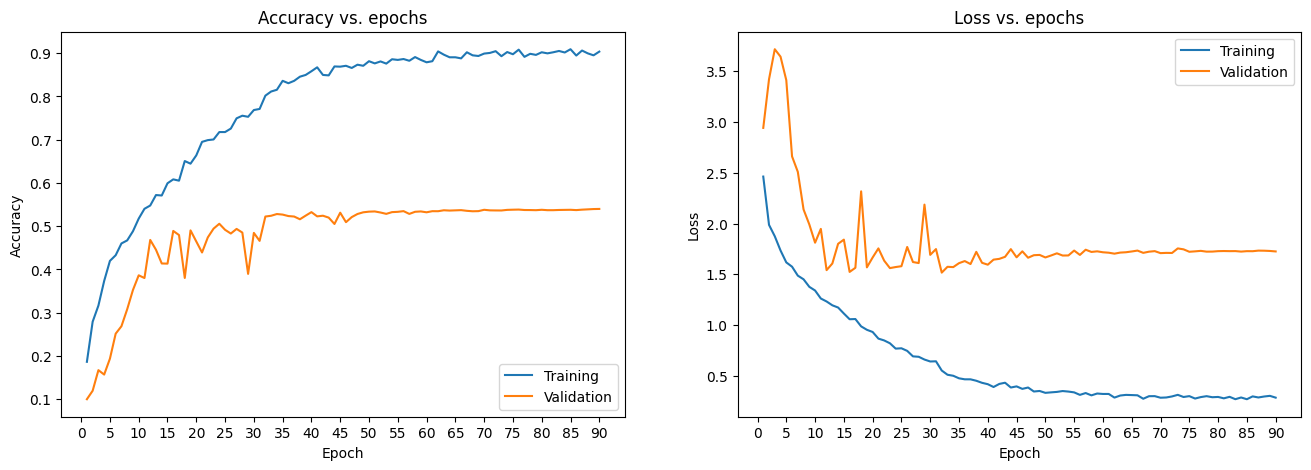

2022-08-16 09:03:53,417: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/custom1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/custom1
----------------------------------------evaluate----------------------------------------
313/313 [==============================] - 1s 2ms/step


2022-08-16 09:03:57,872: INFO: test loss:1.7251
2022-08-16 09:03:57,873: INFO: test accuracy:0.5400
2022-08-16 09:03:57,874: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/results.json
2022-08-16 09:03:57,876: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/results.json
2022-08-16 09:03:57,876: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/default.generator
2022-08-16 09:03:57,877: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/default.generator
2022-08-16 09:03:57,878: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/lenet1


----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-08-16 09:03:58,780: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/default.generator


313/313 [==============================] - 1s 2ms/step


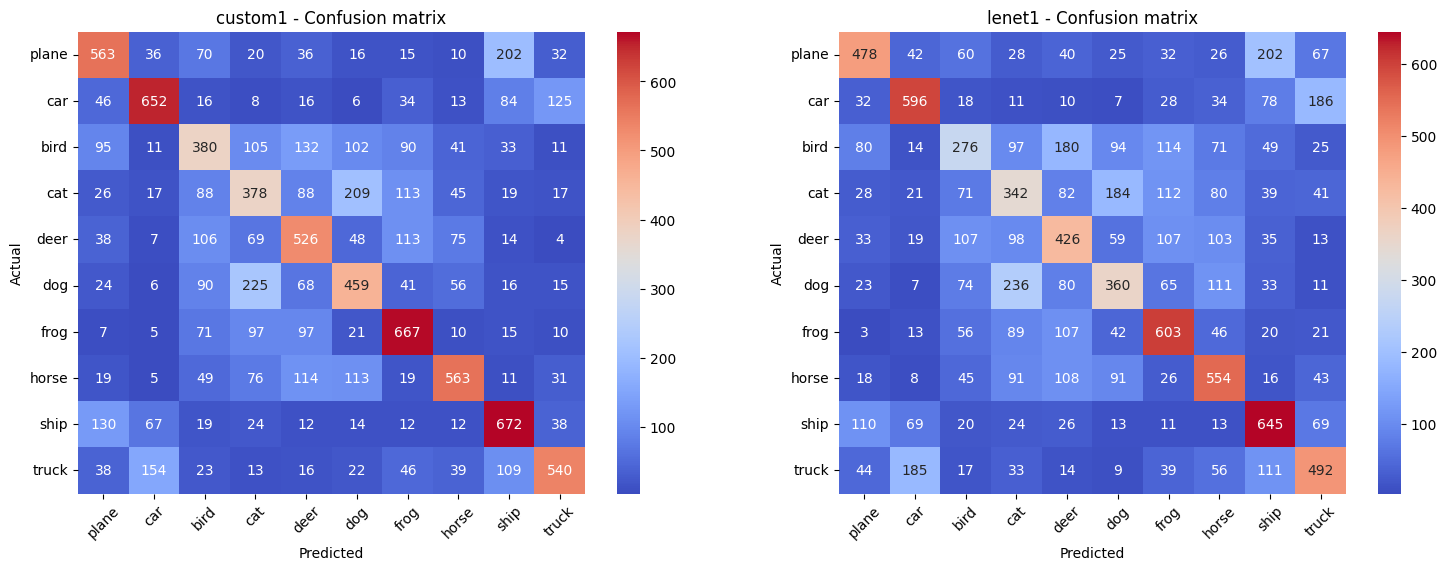

----------------------------------------models----------------------------------------


,model_name,program_name,weight_number,train_time,create_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc
1,custom1,cifar10_0816_cnt_200.ipynb,73738,199.7,2022-08-16 09:03,0.0607,1.7251,0.9925,0.5400,0.9999,0.8987
2,lenet1,cifar10_0816_cnt_200.ipynb,83170,142.9,2022-08-16 09:00,0.0541,2.0866,0.9945,0.4772,0.9998,0.8650
3,mlp1,cifar10_0816_cnt_200.ipynb,394634,80.5,2022-08-16 08:58,1.4637,1.8585,0.5035,0.3463,0.8789,0.7867


In [25]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.custom1(helper, name='custom1', preprocess_fun=rescale)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=False) 

### VGG

In [26]:
rescale1 = tf.keras.layers.Rescaling(1./255.0)
for data, label in datasets.train_dataset.take(1):
    print(data[0][0][0:5]) 
    print(rescale(data)[0][0][0:5])  

tf.Tensor(
[[146 137  59]
 [111 124  46]
 [142 164  60]
 [166 185  47]
 [151 181  23]], shape=(5, 3), dtype=uint8)
tf.Tensor(
[[0.57254905 0.5372549  0.23137257]
 [0.43529415 0.48627454 0.18039216]
 [0.5568628  0.6431373  0.23529413]
 [0.6509804  0.7254902  0.18431373]
 [0.5921569  0.70980394 0.09019608]], shape=(5, 3), dtype=float32)


In [27]:

helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.vgg1(helper, name='vgg8', dense_layer_count=1, block_count=3, 
                                             preprocess_fun=rescale)
model.summary()


2022-08-16 09:04:02,684: INFO: model_params.vgg8.dropout=0.1
2022-08-16 09:04:02,914: INFO: learning_rate=0.001
2022-08-16 09:04:02,915: INFO: model_params.vgg8.clip_value=None
2022-08-16 09:04:02,921: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/vgg8


Model: "vgg8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 block1_con1 (Conv2D)        (None, 32, 32, 64)        1792      
                                                                 
 block1_bn1 (BatchNormalizat  (None, 32, 32, 64)       256       
 ion)                                                            
                                                                 
 block1_relu1 (ReLU)         (None, 32, 32, 64)        0         
                                                                 
 block1_con2 (Conv2D)        (None, 32, 32, 64)        36928     
                                                              

2022-08-16 09:04:03,057: INFO: model_params.vgg8.epochs=90
2022-08-16 09:04:03,058: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/vgg8, monitor=val_accuracy)
2022-08-16 09:04:03,059: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-08-16 09:04:03,060: INFO: use LearningRateScheduler()
2022-08-16 09:04:03,061: INFO: steps_per_epoch=62
2022-08-16 09:04:03,062: INFO: start training
2022-08-16 09:04:03,062: INFO: use_class_weight=False


Epoch 1/90
62/62 [==============================] - ETA: 0s - loss: 2.5912 - accuracy: 0.1744

2022-08-16 09:04:10,297: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/vgg8/assets


2022-08-16 09:04:11,438: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/vgg8/assets


62/62 [==============================] - 8s 105ms/step - loss: 2.5912 - accuracy: 0.1744 - val_loss: 2.3989 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 2/90
61/62 [============================>.] - ETA: 0s - loss: 1.9899 - accuracy: 0.2341

2022-08-16 09:04:17,706: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/vgg8/assets


2022-08-16 09:04:18,856: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/vgg8/assets


62/62 [==============================] - 7s 121ms/step - loss: 1.9928 - accuracy: 0.2329 - val_loss: 2.6175 - val_accuracy: 0.1028 - lr: 0.0010
Epoch 3/90
62/62 [==============================] - 3s 54ms/step - loss: 1.8812 - accuracy: 0.2883 - val_loss: 2.7808 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 4/90
62/62 [==============================] - 4s 59ms/step - loss: 1.7491 - accuracy: 0.3317 - val_loss: 2.9212 - val_accuracy: 0.1003 - lr: 0.0010
Epoch 5/90
62/62 [==============================] - 3s 44ms/step - loss: 1.6592 - accuracy: 0.3755 - val_loss: 3.0324 - val_accuracy: 0.1019 - lr: 0.0010
Epoch 6/90
62/62 [==============================] - ETA: 0s - loss: 1.5372 - accuracy: 0.4224

2022-08-16 09:04:33,604: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/vgg8/assets


2022-08-16 09:04:34,732: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/vgg8/assets


62/62 [==============================] - 6s 102ms/step - loss: 1.5372 - accuracy: 0.4224 - val_loss: 2.5330 - val_accuracy: 0.1473 - lr: 0.0010
Epoch 7/90
62/62 [==============================] - ETA: 0s - loss: 1.4301 - accuracy: 0.4677

2022-08-16 09:04:39,592: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/vgg8/assets


2022-08-16 09:04:40,742: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/vgg8/assets


62/62 [==============================] - 6s 98ms/step - loss: 1.4301 - accuracy: 0.4677 - val_loss: 2.4719 - val_accuracy: 0.1912 - lr: 0.0010
Epoch 8/90
60/62 [============================>.] - ETA: 0s - loss: 1.2678 - accuracy: 0.5297

2022-08-16 09:04:46,106: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/vgg8/assets


2022-08-16 09:04:47,246: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/vgg8/assets


62/62 [==============================] - 7s 106ms/step - loss: 1.2691 - accuracy: 0.5272 - val_loss: 2.2378 - val_accuracy: 0.2732 - lr: 0.0010
Epoch 9/90
61/62 [============================>.] - ETA: 0s - loss: 1.1759 - accuracy: 0.5548

2022-08-16 09:04:52,762: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/vgg8/assets


2022-08-16 09:04:53,888: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/vgg8/assets


62/62 [==============================] - 7s 108ms/step - loss: 1.1767 - accuracy: 0.5544 - val_loss: 1.8422 - val_accuracy: 0.4014 - lr: 0.0010
Epoch 10/90
62/62 [==============================] - 3s 45ms/step - loss: 1.1112 - accuracy: 0.5696 - val_loss: 3.0228 - val_accuracy: 0.2083 - lr: 0.0010
Epoch 11/90
61/62 [============================>.] - ETA: 0s - loss: 0.9916 - accuracy: 0.6276

2022-08-16 09:05:02,317: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/vgg8/assets


2022-08-16 09:05:03,901: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/vgg8/assets


62/62 [==============================] - 7s 118ms/step - loss: 0.9914 - accuracy: 0.6280 - val_loss: 1.7522 - val_accuracy: 0.4420 - lr: 0.0010
Epoch 12/90
62/62 [==============================] - ETA: 0s - loss: 0.9056 - accuracy: 0.6668

2022-08-16 09:05:09,979: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/vgg8/assets


2022-08-16 09:05:11,103: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/vgg8/assets


62/62 [==============================] - 7s 117ms/step - loss: 0.9056 - accuracy: 0.6668 - val_loss: 1.5426 - val_accuracy: 0.4723 - lr: 0.0010
Epoch 13/90
62/62 [==============================] - 3s 57ms/step - loss: 0.8111 - accuracy: 0.6976 - val_loss: 2.0817 - val_accuracy: 0.4113 - lr: 0.0010
Epoch 14/90
59/62 [===========================>..] - ETA: 0s - loss: 0.7734 - accuracy: 0.7219

2022-08-16 09:05:19,949: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/vgg8/assets


2022-08-16 09:05:21,107: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/vgg8/assets


62/62 [==============================] - 7s 106ms/step - loss: 0.7636 - accuracy: 0.7268 - val_loss: 1.5756 - val_accuracy: 0.4882 - lr: 0.0010
Epoch 15/90
62/62 [==============================] - 4s 58ms/step - loss: 0.6706 - accuracy: 0.7475 - val_loss: 1.9676 - val_accuracy: 0.4411 - lr: 0.0010
Epoch 16/90
62/62 [==============================] - 4s 58ms/step - loss: 0.6344 - accuracy: 0.7671 - val_loss: 1.8735 - val_accuracy: 0.4574 - lr: 0.0010
Epoch 17/90
62/62 [==============================] - 3s 42ms/step - loss: 0.5805 - accuracy: 0.7873 - val_loss: 2.1170 - val_accuracy: 0.4071 - lr: 0.0010
Epoch 18/90
62/62 [==============================] - ETA: 0s - loss: 0.5058 - accuracy: 0.8125

2022-08-16 09:05:36,470: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/vgg8/assets


2022-08-16 09:05:37,610: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/vgg8/assets


62/62 [==============================] - 7s 110ms/step - loss: 0.5058 - accuracy: 0.8125 - val_loss: 1.5954 - val_accuracy: 0.5049 - lr: 0.0010
Epoch 19/90
62/62 [==============================] - 2s 35ms/step - loss: 0.4724 - accuracy: 0.8170 - val_loss: 1.7839 - val_accuracy: 0.4788 - lr: 0.0010
Epoch 20/90
62/62 [==============================] - ETA: 0s - loss: 0.4283 - accuracy: 0.8422

2022-08-16 09:05:44,962: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/vgg8/assets


2022-08-16 09:05:46,107: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/vgg8/assets


62/62 [==============================] - 6s 103ms/step - loss: 0.4283 - accuracy: 0.8422 - val_loss: 1.8652 - val_accuracy: 0.5097 - lr: 0.0010
Epoch 21/90
61/62 [============================>.] - ETA: 0s - loss: 0.3776 - accuracy: 0.8709

2022-08-16 09:05:51,386: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/vgg8/assets


2022-08-16 09:05:52,512: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/vgg8/assets


62/62 [==============================] - 6s 104ms/step - loss: 0.3774 - accuracy: 0.8710 - val_loss: 1.6126 - val_accuracy: 0.5256 - lr: 0.0010
Epoch 22/90
62/62 [==============================] - 4s 58ms/step - loss: 0.3850 - accuracy: 0.8659 - val_loss: 2.2940 - val_accuracy: 0.4787 - lr: 0.0010
Epoch 23/90
62/62 [==============================] - 3s 54ms/step - loss: 0.2892 - accuracy: 0.9002 - val_loss: 1.9486 - val_accuracy: 0.5218 - lr: 0.0010
Epoch 24/90
62/62 [==============================] - 2s 36ms/step - loss: 0.2996 - accuracy: 0.8957 - val_loss: 2.0001 - val_accuracy: 0.5035 - lr: 0.0010
Epoch 25/90
61/62 [============================>.] - ETA: 0s - loss: 0.2846 - accuracy: 0.9011

2022-08-16 09:06:06,676: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/vgg8/assets


2022-08-16 09:06:07,821: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/vgg8/assets


62/62 [==============================] - 6s 101ms/step - loss: 0.2842 - accuracy: 0.9007 - val_loss: 1.8031 - val_accuracy: 0.5448 - lr: 0.0010
Epoch 26/90
61/62 [============================>.] - ETA: 0s - loss: 0.2518 - accuracy: 0.9093

2022-08-16 09:06:13,061: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/vgg8/assets


2022-08-16 09:06:14,205: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/vgg8/assets


62/62 [==============================] - 6s 104ms/step - loss: 0.2498 - accuracy: 0.9103 - val_loss: 1.7496 - val_accuracy: 0.5553 - lr: 0.0010
Epoch 27/90
61/62 [============================>.] - ETA: 0s - loss: 0.1974 - accuracy: 0.9303
Epoch 27: ReduceLROnPlateau reducing learning rate to 0.00031622778103685084.
62/62 [==============================] - 4s 58ms/step - loss: 0.1997 - accuracy: 0.9289 - val_loss: 1.8037 - val_accuracy: 0.5418 - lr: 3.1623e-04
Epoch 00028: Still keep learning rate 0.0003162 instead of 0.001
Epoch 28/90
61/62 [============================>.] - ETA: 0s - loss: 0.1751 - accuracy: 0.9370

2022-08-16 09:06:24,155: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/vgg8/assets


2022-08-16 09:06:25,337: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/vgg8/assets


62/62 [==============================] - 8s 123ms/step - loss: 0.1731 - accuracy: 0.9380 - val_loss: 1.7693 - val_accuracy: 0.5688 - lr: 3.1623e-04
Epoch 00029: Still keep learning rate 0.0003162 instead of 0.001
Epoch 29/90
60/62 [============================>.] - ETA: 0s - loss: 0.1383 - accuracy: 0.9526

2022-08-16 09:06:31,250: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/vgg8/assets


2022-08-16 09:06:32,416: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/vgg8/assets


62/62 [==============================] - 7s 116ms/step - loss: 0.1399 - accuracy: 0.9521 - val_loss: 1.6390 - val_accuracy: 0.5891 - lr: 3.1623e-04
Epoch 00030: Still keep learning rate 0.0003162 instead of 0.001
Epoch 30/90
62/62 [==============================] - 3s 44ms/step - loss: 0.1234 - accuracy: 0.9546 - val_loss: 1.6850 - val_accuracy: 0.5864 - lr: 3.1623e-04
Epoch 00031: Still keep learning rate 0.0003162 instead of 0.001
Epoch 31/90
62/62 [==============================] - ETA: 0s - loss: 0.1025 - accuracy: 0.9642

2022-08-16 09:06:41,229: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/vgg8/assets


2022-08-16 09:06:42,378: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/vgg8/assets


62/62 [==============================] - 7s 118ms/step - loss: 0.1025 - accuracy: 0.9642 - val_loss: 1.7204 - val_accuracy: 0.5950 - lr: 3.1623e-04
Epoch 00032: Still keep learning rate 0.0003162 instead of 0.001
Epoch 32/90
62/62 [==============================] - 3s 44ms/step - loss: 0.1180 - accuracy: 0.9567 - val_loss: 1.7233 - val_accuracy: 0.5844 - lr: 3.1623e-04
Epoch 00033: Still keep learning rate 0.0003162 instead of 0.001
Epoch 33/90
62/62 [==============================] - ETA: 0s - loss: 0.1148 - accuracy: 0.9617

2022-08-16 09:06:50,337: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/vgg8/assets


2022-08-16 09:06:51,477: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/vgg8/assets


62/62 [==============================] - 6s 104ms/step - loss: 0.1148 - accuracy: 0.9617 - val_loss: 1.6876 - val_accuracy: 0.5975 - lr: 3.1623e-04
Epoch 00034: Still keep learning rate 0.0003162 instead of 0.001
Epoch 34/90
62/62 [==============================] - 4s 57ms/step - loss: 0.0815 - accuracy: 0.9743 - val_loss: 1.8196 - val_accuracy: 0.5819 - lr: 3.1623e-04
Epoch 00035: Still keep learning rate 0.0003162 instead of 0.001
Epoch 35/90
62/62 [==============================] - 3s 43ms/step - loss: 0.1018 - accuracy: 0.9647 - val_loss: 1.7045 - val_accuracy: 0.5962 - lr: 3.1623e-04
Epoch 00036: Still keep learning rate 0.0003162 instead of 0.001
Epoch 36/90
62/62 [==============================] - 3s 49ms/step - loss: 0.0823 - accuracy: 0.9723 - val_loss: 1.7504 - val_accuracy: 0.5913 - lr: 3.1623e-04
Epoch 00037: Still keep learning rate 0.0003162 instead of 0.001
Epoch 37/90
62/62 [==============================] - 3s 49ms/step - loss: 0.0907 - accuracy: 0.9708 - val_loss: 1.8

2022-08-16 09:07:27,259: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/vgg8/assets


2022-08-16 09:07:28,415: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/vgg8/assets


62/62 [==============================] - 7s 118ms/step - loss: 0.0730 - accuracy: 0.9768 - val_loss: 1.8181 - val_accuracy: 0.6003 - lr: 1.0000e-04
Epoch 00044: Still keep learning rate 0.0001 instead of 0.001
Epoch 44/90
60/62 [============================>.] - ETA: 0s - loss: 0.0775 - accuracy: 0.9745

2022-08-16 09:07:34,344: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/vgg8/assets


2022-08-16 09:07:35,471: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/vgg8/assets


62/62 [==============================] - 7s 115ms/step - loss: 0.0780 - accuracy: 0.9743 - val_loss: 1.8280 - val_accuracy: 0.6023 - lr: 1.0000e-04
Epoch 00045: Still keep learning rate 0.0001 instead of 0.001
Epoch 45/90
62/62 [==============================] - 3s 56ms/step - loss: 0.0634 - accuracy: 0.9808 - val_loss: 1.8538 - val_accuracy: 0.6005 - lr: 1.0000e-04
Epoch 00046: Still keep learning rate 0.0001 instead of 0.001
Epoch 46/90
61/62 [============================>.] - ETA: 0s - loss: 0.0614 - accuracy: 0.9805

2022-08-16 09:07:44,157: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/vgg8/assets


2022-08-16 09:07:45,601: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/vgg8/assets


62/62 [==============================] - 7s 109ms/step - loss: 0.0611 - accuracy: 0.9803 - val_loss: 1.8753 - val_accuracy: 0.6041 - lr: 1.0000e-04
Epoch 00047: Still keep learning rate 0.0001 instead of 0.001
Epoch 47/90
62/62 [==============================] - ETA: 0s - loss: 0.0619 - accuracy: 0.9829

2022-08-16 09:07:51,741: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/vgg8/assets


2022-08-16 09:07:52,874: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/vgg8/assets


62/62 [==============================] - 7s 118ms/step - loss: 0.0619 - accuracy: 0.9829 - val_loss: 1.8342 - val_accuracy: 0.6061 - lr: 1.0000e-04
Epoch 00048: Still keep learning rate 0.0001 instead of 0.001
Epoch 48/90
60/62 [============================>.] - ETA: 0s - loss: 0.0619 - accuracy: 0.9786

2022-08-16 09:07:58,946: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/vgg8/assets


2022-08-16 09:08:00,458: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/vgg8/assets


62/62 [==============================] - 8s 124ms/step - loss: 0.0603 - accuracy: 0.9793 - val_loss: 1.8716 - val_accuracy: 0.6065 - lr: 1.0000e-04
Epoch 00049: Still keep learning rate 0.0001 instead of 0.001
Epoch 49/90
62/62 [==============================] - 3s 48ms/step - loss: 0.0600 - accuracy: 0.9798 - val_loss: 1.8584 - val_accuracy: 0.6044 - lr: 1.0000e-04
Epoch 00050: Still keep learning rate 0.0001 instead of 0.001
Epoch 50/90
62/62 [==============================] - 3s 45ms/step - loss: 0.0609 - accuracy: 0.9798 - val_loss: 1.8948 - val_accuracy: 0.6040 - lr: 1.0000e-04
Epoch 00051: Still keep learning rate 0.0001 instead of 0.001
Epoch 51/90
62/62 [==============================] - ETA: 0s - loss: 0.0551 - accuracy: 0.9849

2022-08-16 09:08:12,265: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/vgg8/assets


2022-08-16 09:08:13,410: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/vgg8/assets


62/62 [==============================] - 7s 118ms/step - loss: 0.0551 - accuracy: 0.9849 - val_loss: 1.8881 - val_accuracy: 0.6077 - lr: 1.0000e-04
Epoch 00052: Still keep learning rate 0.0001 instead of 0.001
Epoch 52/90
62/62 [==============================] - 3s 55ms/step - loss: 0.0555 - accuracy: 0.9844 - val_loss: 1.8900 - val_accuracy: 0.6062 - lr: 1.0000e-04
Epoch 00053: Still keep learning rate 0.0001 instead of 0.001
Epoch 53/90
60/62 [============================>.] - ETA: 0s - loss: 0.0629 - accuracy: 0.9802

2022-08-16 09:08:23,175: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/vgg8/assets


2022-08-16 09:08:24,353: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/vgg8/assets


62/62 [==============================] - 8s 124ms/step - loss: 0.0617 - accuracy: 0.9808 - val_loss: 1.8785 - val_accuracy: 0.6080 - lr: 1.0000e-04
Epoch 00054: Still keep learning rate 0.0001 instead of 0.001
Epoch 54/90
62/62 [==============================] - 3s 53ms/step - loss: 0.0538 - accuracy: 0.9844 - val_loss: 1.9135 - val_accuracy: 0.6057 - lr: 1.0000e-04
Epoch 00055: Still keep learning rate 0.0001 instead of 0.001
Epoch 55/90
62/62 [==============================] - 3s 42ms/step - loss: 0.0636 - accuracy: 0.9798 - val_loss: 1.9656 - val_accuracy: 0.6078 - lr: 1.0000e-04
Epoch 00056: Still keep learning rate 0.0001 instead of 0.001
Epoch 56/90
62/62 [==============================] - 4s 58ms/step - loss: 0.0517 - accuracy: 0.9814 - val_loss: 1.9313 - val_accuracy: 0.6052 - lr: 1.0000e-04
Epoch 00057: Still keep learning rate 0.0001 instead of 0.001
Epoch 57/90
61/62 [============================>.] - ETA: 0s - loss: 0.0531 - accuracy: 0.9826

2022-08-16 09:08:39,851: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/vgg8/assets


2022-08-16 09:08:40,999: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/vgg8/assets



Epoch 57: ReduceLROnPlateau reducing learning rate to 3.1622778103685084e-05.
62/62 [==============================] - 7s 118ms/step - loss: 0.0532 - accuracy: 0.9824 - val_loss: 1.9241 - val_accuracy: 0.6089 - lr: 3.1623e-05
Epoch 00058: LearningRateScheduler reducing learning rate to 0.001 from 3.16e-05.
Epoch 58/90
62/62 [==============================] - 4s 59ms/step - loss: 0.2387 - accuracy: 0.9183 - val_loss: 8.2822 - val_accuracy: 0.2056 - lr: 0.0010
Epoch 59/90
62/62 [==============================] - 3s 54ms/step - loss: 0.9205 - accuracy: 0.6754 - val_loss: 2.5988 - val_accuracy: 0.4896 - lr: 0.0010
Epoch 60/90
62/62 [==============================] - 6s 93ms/step - loss: 0.5991 - accuracy: 0.7828 - val_loss: 3.8357 - val_accuracy: 0.3962 - lr: 0.0010
Epoch 00061: LearningRateScheduler reducing learning rate to 0.0001 from 0.001.
Epoch 61/90
62/62 [==============================] - 6s 93ms/step - loss: 0.2911 - accuracy: 0.8931 - val_loss: 2.0000 - val_accuracy: 0.5586 - lr

2022-08-16 09:10:50,197: INFO: finish training [elapsed time: 407.14 seconds]


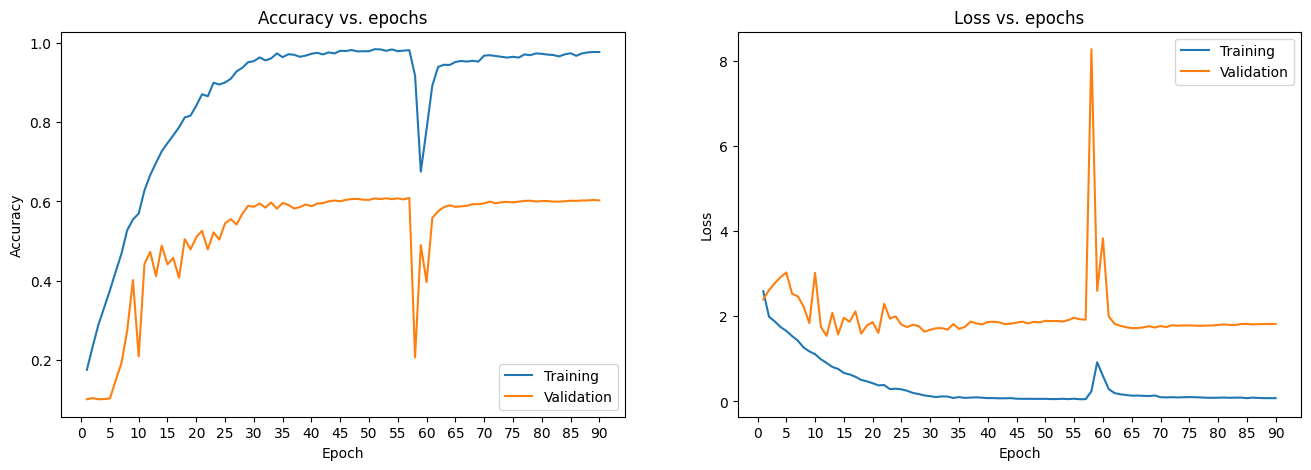

2022-08-16 09:10:50,665: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/vgg8


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/vgg8
----------------------------------------evaluate----------------------------------------
313/313 [==============================] - 1s 3ms/step


2022-08-16 09:10:57,109: INFO: test loss:1.9241
2022-08-16 09:10:57,110: INFO: test accuracy:0.6089
2022-08-16 09:10:57,113: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/results.json
2022-08-16 09:10:57,114: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/results.json
2022-08-16 09:10:57,115: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/default.generator
2022-08-16 09:10:57,116: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/default.generator
2022-08-16 09:10:57,116: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/custom1


----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-08-16 09:10:58,157: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/default.generator


313/313 [==============================] - 1s 2ms/step


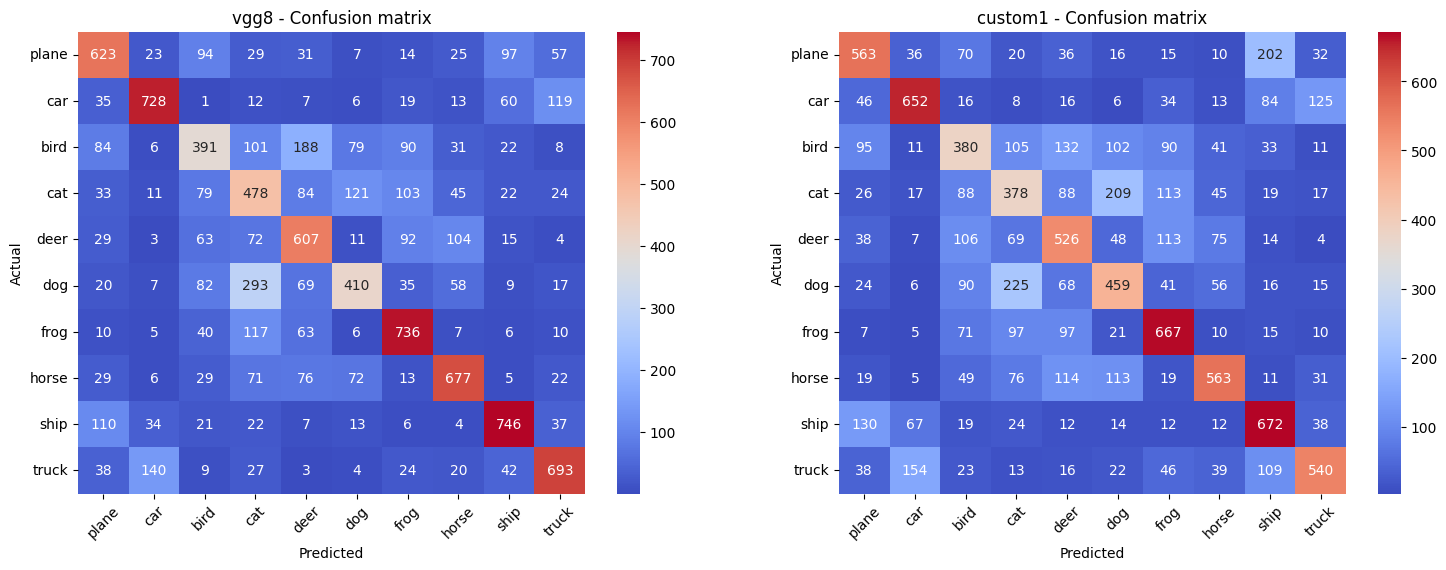

----------------------------------------models----------------------------------------


,model_name,program_name,weight_number,train_time,create_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc
1,vgg8,cifar10_0816_cnt_200.ipynb,1672906,407.1,2022-08-16 09:10,0.0139,1.9241,0.9970,0.6089,1.0000,0.9188
2,custom1,cifar10_0816_cnt_200.ipynb,73738,199.7,2022-08-16 09:03,0.0607,1.7251,0.9925,0.5400,0.9999,0.8987
3,lenet1,cifar10_0816_cnt_200.ipynb,83170,142.9,2022-08-16 09:00,0.0541,2.0866,0.9945,0.4772,0.9998,0.8650
4,mlp1,cifar10_0816_cnt_200.ipynb,394634,80.5,2022-08-16 08:58,1.4637,1.8585,0.5035,0.3463,0.8789,0.7867


In [28]:
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=False) 

### Resnet

see https://github.com/PacktPublishing/Advanced-Deep-Learning-with-Keras/blob/master/chapter2-deep-networks/resnet-cifar10-2.2.1.py

2022-08-16 09:11:02,721: INFO: learning_rate=0.001
2022-08-16 09:11:02,721: INFO: model_params.resnet_v1_20.clip_value=None
2022-08-16 09:11:02,728: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/resnet_v1_20


Model: "resnet_v1_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 32, 32, 3)    0           ['input_5[0][0]']                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 32, 32, 16)   448         ['rescaling[4][0]']              
                                                                                                  
 batch_normalization_5 (BatchNo  (None, 32, 32, 16)  64          ['conv2d_5[0][0]']               
 rmalization)                                                                          

                                                                                                  
 conv2d_15 (Conv2D)             (None, 16, 16, 32)   9248        ['activation_8[0][0]']           
                                                                                                  
 batch_normalization_14 (BatchN  (None, 16, 16, 32)  128         ['conv2d_15[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_9 (Activation)      (None, 16, 16, 32)   0           ['batch_normalization_14[0][0]'] 
                                                                                                  
 conv2d_16 (Conv2D)             (None, 16, 16, 32)   9248        ['activation_9[0][0]']           
                                                                                                  
 batch_nor

 add_8 (Add)                    (None, 8, 8, 64)     0           ['activation_16[0][0]',          
                                                                  'batch_normalization_23[0][0]'] 
                                                                                                  
 activation_18 (Activation)     (None, 8, 8, 64)     0           ['add_8[0][0]']                  
                                                                                                  
 average_pooling2d (AveragePool  (None, 1, 1, 64)    0           ['activation_18[0][0]']          
 ing2D)                                                                                           
                                                                                                  
 flatten_4 (Flatten)            (None, 64)           0           ['average_pooling2d[0][0]']      
                                                                                                  
 dense_9 (

2022-08-16 09:11:02,850: INFO: model_params.resnet_v1_20.epochs=90
2022-08-16 09:11:02,851: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/resnet_v1_20, monitor=val_accuracy)
2022-08-16 09:11:02,851: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-08-16 09:11:02,852: INFO: use LearningRateScheduler()
2022-08-16 09:11:02,853: INFO: steps_per_epoch=62
2022-08-16 09:11:02,853: INFO: start training
2022-08-16 09:11:02,854: INFO: use_class_weight=False


Epoch 1/90
61/62 [============================>.] - ETA: 0s - loss: 2.3012 - accuracy: 0.2459

2022-08-16 09:11:17,942: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/resnet_v1_20/assets


2022-08-16 09:11:21,038: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/resnet_v1_20/assets


62/62 [==============================] - 18s 241ms/step - loss: 2.2999 - accuracy: 0.2465 - val_loss: 2.8735 - val_accuracy: 0.1674 - lr: 0.0010
Epoch 2/90
62/62 [==============================] - ETA: 0s - loss: 1.8009 - accuracy: 0.3921

2022-08-16 09:11:35,193: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/resnet_v1_20/assets


2022-08-16 09:11:38,238: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/resnet_v1_20/assets


62/62 [==============================] - 17s 281ms/step - loss: 1.8009 - accuracy: 0.3921 - val_loss: 3.2469 - val_accuracy: 0.1698 - lr: 0.0010
Epoch 3/90
62/62 [==============================] - 3s 52ms/step - loss: 1.5304 - accuracy: 0.5101 - val_loss: 4.2313 - val_accuracy: 0.1501 - lr: 0.0010
Epoch 4/90
62/62 [==============================] - 3s 54ms/step - loss: 1.2139 - accuracy: 0.6406 - val_loss: 6.2756 - val_accuracy: 0.1375 - lr: 0.0010
Epoch 5/90
62/62 [==============================] - 4s 62ms/step - loss: 0.9596 - accuracy: 0.7273 - val_loss: 5.5846 - val_accuracy: 0.1437 - lr: 0.0010
Epoch 6/90
60/62 [============================>.] - ETA: 0s - loss: 0.8731 - accuracy: 0.7542

2022-08-16 09:11:59,646: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/resnet_v1_20/assets


2022-08-16 09:12:02,980: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/resnet_v1_20/assets


62/62 [==============================] - 14s 235ms/step - loss: 0.8696 - accuracy: 0.7555 - val_loss: 4.4492 - val_accuracy: 0.2438 - lr: 0.0010
Epoch 7/90
62/62 [==============================] - 7s 110ms/step - loss: 0.8246 - accuracy: 0.7707 - val_loss: 5.5960 - val_accuracy: 0.1997 - lr: 0.0010
Epoch 8/90
62/62 [==============================] - ETA: 0s - loss: 0.6695 - accuracy: 0.8322

2022-08-16 09:12:22,081: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/resnet_v1_20/assets


2022-08-16 09:12:25,193: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/resnet_v1_20/assets


62/62 [==============================] - 16s 254ms/step - loss: 0.6695 - accuracy: 0.8322 - val_loss: 3.1203 - val_accuracy: 0.3167 - lr: 0.0010
Epoch 9/90
62/62 [==============================] - 4s 57ms/step - loss: 0.4957 - accuracy: 0.9032 - val_loss: 3.9295 - val_accuracy: 0.3154 - lr: 0.0010
Epoch 10/90
62/62 [==============================] - 4s 60ms/step - loss: 0.3877 - accuracy: 0.9400 - val_loss: 6.9220 - val_accuracy: 0.1356 - lr: 0.0010
Epoch 11/90
62/62 [==============================] - 4s 66ms/step - loss: 0.3425 - accuracy: 0.9561 - val_loss: 4.8134 - val_accuracy: 0.2728 - lr: 0.0010
Epoch 12/90
62/62 [==============================] - ETA: 0s - loss: 0.2721 - accuracy: 0.9793

2022-08-16 09:12:50,874: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/resnet_v1_20/assets


2022-08-16 09:12:53,973: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/resnet_v1_20/assets


62/62 [==============================] - 17s 283ms/step - loss: 0.2721 - accuracy: 0.9793 - val_loss: 3.5436 - val_accuracy: 0.3505 - lr: 0.0010
Epoch 13/90
62/62 [==============================] - 3s 56ms/step - loss: 0.2361 - accuracy: 0.9904 - val_loss: 5.2068 - val_accuracy: 0.2843 - lr: 0.0010
Epoch 14/90
62/62 [==============================] - 4s 63ms/step - loss: 0.2186 - accuracy: 0.9929 - val_loss: 3.5755 - val_accuracy: 0.3229 - lr: 0.0010
Epoch 15/90
62/62 [==============================] - 3s 56ms/step - loss: 0.1964 - accuracy: 0.9980 - val_loss: 3.9640 - val_accuracy: 0.3030 - lr: 0.0010
Epoch 16/90
61/62 [============================>.] - ETA: 0s - loss: 0.1802 - accuracy: 0.9985
Epoch 16: ReduceLROnPlateau reducing learning rate to 0.00031622778103685084.
62/62 [==============================] - 4s 57ms/step - loss: 0.1801 - accuracy: 0.9985 - val_loss: 3.2182 - val_accuracy: 0.3502 - lr: 3.1623e-04
Epoch 00017: Still keep learning rate 0.0003162 instead of 0.001
Epoch

2022-08-16 09:13:19,225: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/resnet_v1_20/assets


2022-08-16 09:13:22,504: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/resnet_v1_20/assets


62/62 [==============================] - 14s 233ms/step - loss: 0.1729 - accuracy: 0.9995 - val_loss: 2.7588 - val_accuracy: 0.3970 - lr: 3.1623e-04
Epoch 00018: Still keep learning rate 0.0003162 instead of 0.001
Epoch 18/90
62/62 [==============================] - ETA: 0s - loss: 0.1700 - accuracy: 1.0000

2022-08-16 09:13:36,158: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/resnet_v1_20/assets


2022-08-16 09:13:39,733: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/resnet_v1_20/assets


62/62 [==============================] - 17s 282ms/step - loss: 0.1700 - accuracy: 1.0000 - val_loss: 2.7311 - val_accuracy: 0.3998 - lr: 3.1623e-04
Epoch 00019: Still keep learning rate 0.0003162 instead of 0.001
Epoch 19/90
61/62 [============================>.] - ETA: 0s - loss: 0.1693 - accuracy: 1.0000

2022-08-16 09:13:50,728: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/resnet_v1_20/assets


2022-08-16 09:13:53,854: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/resnet_v1_20/assets


62/62 [==============================] - 14s 231ms/step - loss: 0.1693 - accuracy: 1.0000 - val_loss: 2.7230 - val_accuracy: 0.3999 - lr: 3.1623e-04
Epoch 00020: Still keep learning rate 0.0003162 instead of 0.001
Epoch 20/90
60/62 [============================>.] - ETA: 0s - loss: 0.1686 - accuracy: 1.0000

2022-08-16 09:14:05,879: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/resnet_v1_20/assets


2022-08-16 09:14:08,987: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/resnet_v1_20/assets


62/62 [==============================] - 15s 248ms/step - loss: 0.1686 - accuracy: 1.0000 - val_loss: 2.7232 - val_accuracy: 0.4016 - lr: 3.1623e-04
Epoch 00021: Still keep learning rate 0.0003162 instead of 0.001
Epoch 21/90
62/62 [==============================] - ETA: 0s - loss: 0.1680 - accuracy: 1.0000

2022-08-16 09:14:22,680: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/resnet_v1_20/assets


2022-08-16 09:14:26,000: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/resnet_v1_20/assets


62/62 [==============================] - 17s 277ms/step - loss: 0.1680 - accuracy: 1.0000 - val_loss: 2.7235 - val_accuracy: 0.4032 - lr: 3.1623e-04
Epoch 00022: Still keep learning rate 0.0003162 instead of 0.001
Epoch 22/90
62/62 [==============================] - 3s 52ms/step - loss: 0.1675 - accuracy: 1.0000 - val_loss: 2.7238 - val_accuracy: 0.4027 - lr: 3.1623e-04
Epoch 00023: Still keep learning rate 0.0003162 instead of 0.001
Epoch 23/90
62/62 [==============================] - 4s 65ms/step - loss: 0.1669 - accuracy: 1.0000 - val_loss: 2.7243 - val_accuracy: 0.4026 - lr: 3.1623e-04
Epoch 00024: Still keep learning rate 0.0003162 instead of 0.001
Epoch 24/90
62/62 [==============================] - 4s 68ms/step - loss: 0.1664 - accuracy: 1.0000 - val_loss: 2.7249 - val_accuracy: 0.4029 - lr: 3.1623e-04
Epoch 00025: Still keep learning rate 0.0003162 instead of 0.001
Epoch 25/90
62/62 [==============================] - ETA: 0s - loss: 0.1658 - accuracy: 1.0000

2022-08-16 09:14:51,628: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/resnet_v1_20/assets


2022-08-16 09:14:55,368: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/resnet_v1_20/assets


62/62 [==============================] - 18s 294ms/step - loss: 0.1658 - accuracy: 1.0000 - val_loss: 2.7258 - val_accuracy: 0.4035 - lr: 3.1623e-04
Epoch 00026: Still keep learning rate 0.0003162 instead of 0.001
Epoch 26/90
62/62 [==============================] - 4s 58ms/step - loss: 0.1653 - accuracy: 1.0000 - val_loss: 2.7270 - val_accuracy: 0.4034 - lr: 3.1623e-04
Epoch 00027: Still keep learning rate 0.0003162 instead of 0.001
Epoch 27/90
61/62 [============================>.] - ETA: 0s - loss: 0.1647 - accuracy: 1.0000

2022-08-16 09:15:09,925: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/resnet_v1_20/assets


2022-08-16 09:15:13,077: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/resnet_v1_20/assets


62/62 [==============================] - 14s 231ms/step - loss: 0.1647 - accuracy: 1.0000 - val_loss: 2.7283 - val_accuracy: 0.4039 - lr: 3.1623e-04
Epoch 00028: Still keep learning rate 0.0003162 instead of 0.001
Epoch 28/90
62/62 [==============================] - 4s 65ms/step - loss: 0.1641 - accuracy: 1.0000 - val_loss: 2.7297 - val_accuracy: 0.4039 - lr: 3.1623e-04
Epoch 00029: Still keep learning rate 0.0003162 instead of 0.001
Epoch 29/90
62/62 [==============================] - ETA: 0s - loss: 0.1636 - accuracy: 1.0000

2022-08-16 09:15:29,941: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/resnet_v1_20/assets


2022-08-16 09:15:33,062: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/resnet_v1_20/assets


62/62 [==============================] - 16s 261ms/step - loss: 0.1636 - accuracy: 1.0000 - val_loss: 2.7312 - val_accuracy: 0.4041 - lr: 3.1623e-04
Epoch 00030: Still keep learning rate 0.0003162 instead of 0.001
Epoch 30/90
62/62 [==============================] - ETA: 0s - loss: 0.1630 - accuracy: 1.0000

2022-08-16 09:15:47,167: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/resnet_v1_20/assets


2022-08-16 09:15:50,543: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/resnet_v1_20/assets


62/62 [==============================] - 17s 285ms/step - loss: 0.1630 - accuracy: 1.0000 - val_loss: 2.7328 - val_accuracy: 0.4042 - lr: 3.1623e-04
Epoch 00031: Still keep learning rate 0.0003162 instead of 0.001
Epoch 31/90
61/62 [============================>.] - ETA: 0s - loss: 0.1624 - accuracy: 1.0000

2022-08-16 09:16:01,318: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/resnet_v1_20/assets


2022-08-16 09:16:05,008: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/resnet_v1_20/assets


62/62 [==============================] - 14s 237ms/step - loss: 0.1624 - accuracy: 1.0000 - val_loss: 2.7345 - val_accuracy: 0.4047 - lr: 3.1623e-04
Epoch 00032: Still keep learning rate 0.0003162 instead of 0.001
Epoch 32/90
62/62 [==============================] - ETA: 0s - loss: 0.1617 - accuracy: 1.0000

2022-08-16 09:16:18,620: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/resnet_v1_20/assets


2022-08-16 09:16:22,235: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/resnet_v1_20/assets


62/62 [==============================] - 17s 282ms/step - loss: 0.1617 - accuracy: 1.0000 - val_loss: 2.7362 - val_accuracy: 0.4051 - lr: 3.1623e-04
Epoch 00033: Still keep learning rate 0.0003162 instead of 0.001
Epoch 33/90
62/62 [==============================] - ETA: 0s - loss: 0.1611 - accuracy: 1.0000

2022-08-16 09:16:35,770: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/resnet_v1_20/assets


2022-08-16 09:16:39,105: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/resnet_v1_20/assets


62/62 [==============================] - 17s 275ms/step - loss: 0.1611 - accuracy: 1.0000 - val_loss: 2.7379 - val_accuracy: 0.4053 - lr: 3.1623e-04
Epoch 00034: Still keep learning rate 0.0003162 instead of 0.001
Epoch 34/90
61/62 [============================>.] - ETA: 0s - loss: 0.1605 - accuracy: 1.0000
Epoch 34: ReduceLROnPlateau reducing learning rate to 0.00010000000639606199.
62/62 [==============================] - 4s 58ms/step - loss: 0.1605 - accuracy: 1.0000 - val_loss: 2.7397 - val_accuracy: 0.4051 - lr: 1.0000e-04
Epoch 00035: Still keep learning rate 0.0001 instead of 0.001
Epoch 35/90
60/62 [============================>.] - ETA: 0s - loss: 0.1600 - accuracy: 1.0000

2022-08-16 09:16:53,894: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/resnet_v1_20/assets


2022-08-16 09:16:56,973: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/resnet_v1_20/assets


62/62 [==============================] - 14s 234ms/step - loss: 0.1600 - accuracy: 1.0000 - val_loss: 2.7477 - val_accuracy: 0.4058 - lr: 1.0000e-04
Epoch 00036: Still keep learning rate 0.0001 instead of 0.001
Epoch 36/90
62/62 [==============================] - 7s 120ms/step - loss: 0.1598 - accuracy: 1.0000 - val_loss: 2.7526 - val_accuracy: 0.4053 - lr: 1.0000e-04
Epoch 00037: Still keep learning rate 0.0001 instead of 0.001
Epoch 37/90
62/62 [==============================] - 7s 114ms/step - loss: 0.1596 - accuracy: 1.0000 - val_loss: 2.7555 - val_accuracy: 0.4053 - lr: 1.0000e-04
Epoch 00038: Still keep learning rate 0.0001 instead of 0.001
Epoch 38/90
62/62 [==============================] - 8s 125ms/step - loss: 0.1594 - accuracy: 1.0000 - val_loss: 2.7574 - val_accuracy: 0.4054 - lr: 1.0000e-04
Epoch 00039: Still keep learning rate 0.0001 instead of 0.001
Epoch 39/90
62/62 [==============================] - 7s 117ms/step - loss: 0.1591 - accuracy: 1.0000 - val_loss: 2.7588 - v

Epoch 00076: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 76/90
62/62 [==============================] - 4s 67ms/step - loss: 0.1201 - accuracy: 1.0000 - val_loss: 2.8852 - val_accuracy: 0.4036 - lr: 3.1623e-05
Epoch 00077: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 77/90
62/62 [==============================] - 6s 97ms/step - loss: 0.1200 - accuracy: 1.0000 - val_loss: 2.8853 - val_accuracy: 0.4034 - lr: 3.1623e-05
Epoch 00078: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 78/90
62/62 [==============================] - 6s 97ms/step - loss: 0.1198 - accuracy: 1.0000 - val_loss: 2.8854 - val_accuracy: 0.4033 - lr: 3.1623e-05
Epoch 00079: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 79/90
62/62 [==============================] - 6s 102ms/step - loss: 0.1197 - accuracy: 1.0000 - val_loss: 2.8854 - val_accuracy: 0.4033 - lr: 3.1623e-05
Epoch 00080: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 80/90
62/62 [===================

2022-08-16 09:21:31,667: INFO: finish training [elapsed time: 628.81 seconds]


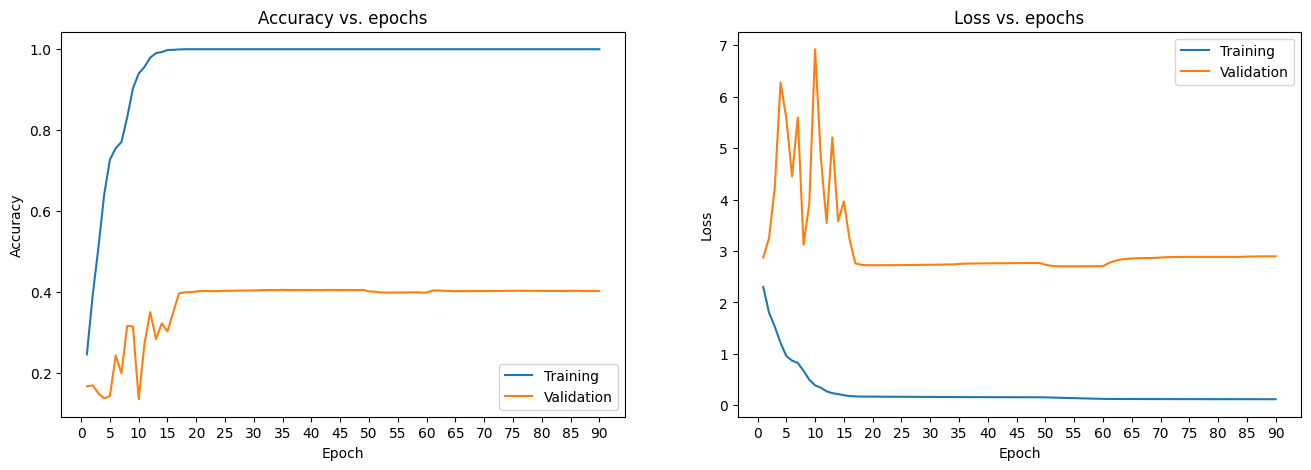

2022-08-16 09:21:32,088: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/resnet_v1_20


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/resnet_v1_20
----------------------------------------evaluate----------------------------------------
313/313 [==============================] - 2s 6ms/step


2022-08-16 09:21:43,434: INFO: test loss:2.7477
2022-08-16 09:21:43,435: INFO: test accuracy:0.4058
2022-08-16 09:21:43,439: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/results.json
2022-08-16 09:21:43,441: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/results.json
2022-08-16 09:21:43,442: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/default.generator
2022-08-16 09:21:43,443: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/default.generator
2022-08-16 09:21:43,443: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/vgg8


----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-08-16 09:21:45,269: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/default.generator


313/313 [==============================] - 1s 3ms/step


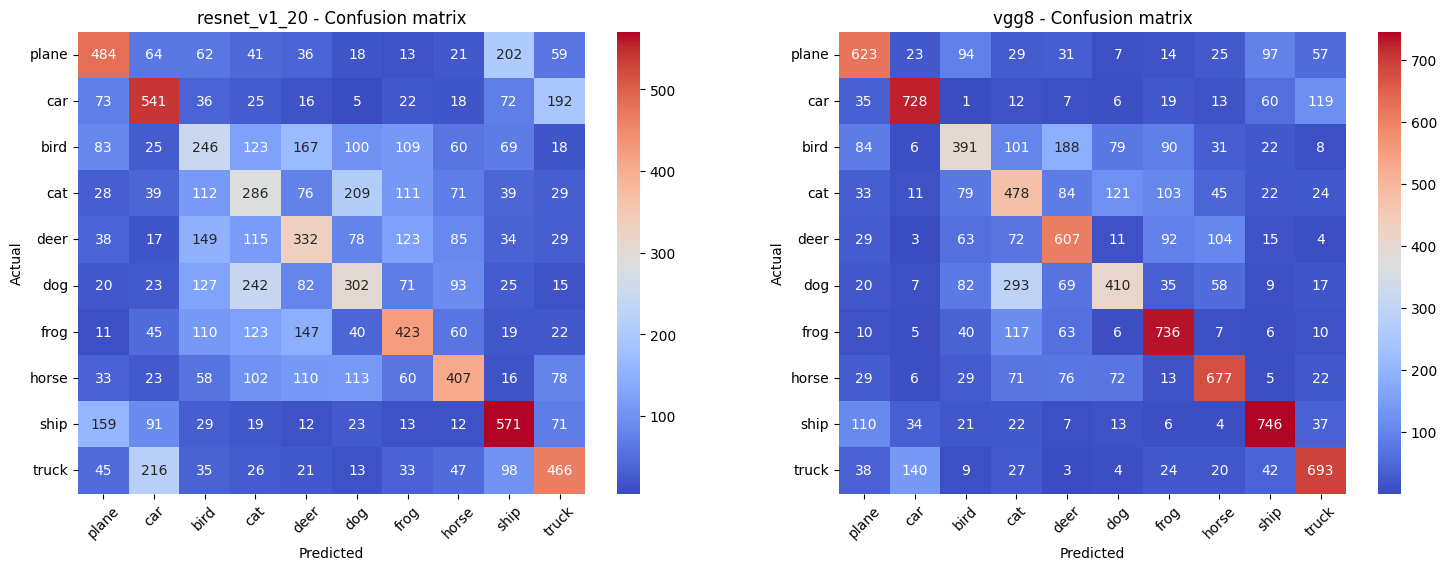

----------------------------------------models----------------------------------------


,model_name,program_name,weight_number,train_time,create_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc
1,vgg8,cifar10_0816_cnt_200.ipynb,1672906,407.1,2022-08-16 09:10,0.0139,1.9241,0.9970,0.6089,1.0000,0.9188
2,custom1,cifar10_0816_cnt_200.ipynb,73738,199.7,2022-08-16 09:03,0.0607,1.7251,0.9925,0.5400,0.9999,0.8987
3,lenet1,cifar10_0816_cnt_200.ipynb,83170,142.9,2022-08-16 09:00,0.0541,2.0866,0.9945,0.4772,0.9998,0.8650
4,resnet_v1_20,cifar10_0816_cnt_200.ipynb,273066,628.8,2022-08-16 09:21,0.1733,2.7477,0.9970,0.4058,1.0000,0.8189
5,mlp1,cifar10_0816_cnt_200.ipynb,394634,80.5,2022-08-16 08:58,1.4637,1.8585,0.5035,0.3463,0.8789,0.7867


In [29]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.resnet_v1(helper, name='resnet_v1', depth=20, preprocess_fun=rescale)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=False) 

### Pretrained Model + Fune-Tune

In [23]:
class ResizeLayer(tf.keras.layers.Layer):
    def __init__(self, shape):
        super(ResizeLayer, self).__init__()
        self.shape = shape

    def call(self, inputs, training=False):
#         print(type(inputs))
#         return tf.convert_to_tensor(resize_images(inputs.numpy(), self.shape))
        return tf.image.resize(inputs, self.shape)

In [24]:
rescale1 = tf.keras.layers.Rescaling(1./127.5, offset=-1)
input_shape = [160, 160, 3]

In [25]:
preprocess_fun =  [ResizeLayer(input_shape[:-1]), rescale1]

(32, 160, 160, 3) <class 'tensorflow.python.framework.ops.EagerTensor'>


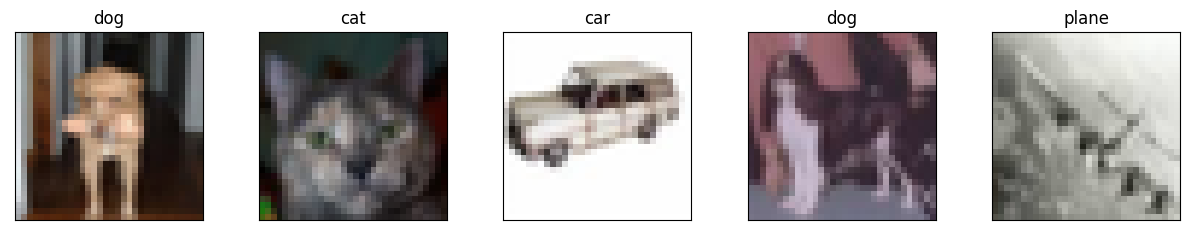

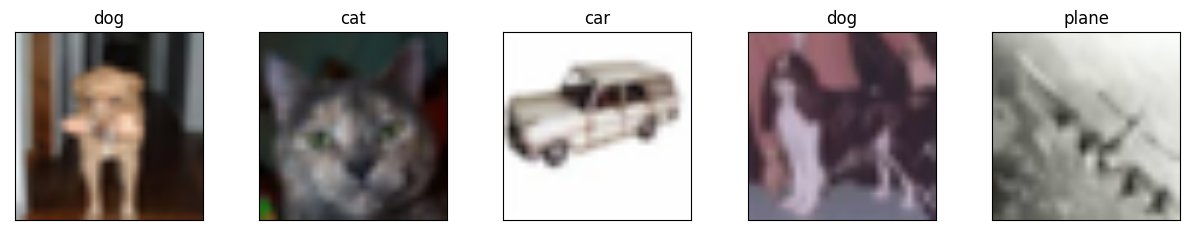

In [26]:
sample_images1 = ResizeLayer(input_shape[:-1])(sample_images)
print(sample_images1.shape, type(sample_images1)) 
qtf.utils.show_images(sample_images.numpy(), sample_labels, classes=params.classes, x_num=1, y_num=5, figsize=(12, 3))
qtf.utils.show_images(sample_images1.numpy(), sample_labels, classes=params.classes, x_num=1, y_num=5, figsize=(12, 3))

#### MobileNet V2

In [27]:
base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 20, 20, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_depthwise_relu (ReLU)  (None, 20, 20, 144)  0           ['block_3_depthwise_BN[0][0]']   
                                                                                                  
 block_3_project (Conv2D)       (None, 20, 20, 32)   4608        ['block_3_depthwise_relu[0][0]'] 
                                                                                                  
 block_3_project_BN (BatchNorma  (None, 20, 20, 32)  128         ['block_3_project[0][0]']        
 lization)

 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 10, 10, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 10, 10, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_7_depthwise_BN (BatchNor  (None, 10, 10, 384)  1536       ['block_7_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_7_d

 block_10_project_BN (BatchNorm  (None, 10, 10, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 10, 10, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_expand_BN (BatchNorma  (None, 10, 10, 576)  2304       ['block_11_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_11_expand_relu (ReLU)    (None, 10, 10, 576)  0           ['block_11_expand_BN[0][0]']     
                                                                                                  
 block_11_

                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 5, 5, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 5, 5, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_project_BN (BatchNorm  (None, 5, 5, 160)   640         ['block_14_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_add (Add)             (None, 5, 5, 160)    0           ['block_13_project_BN[0][0]',    
                                                                  'block_14_project_BN[0][0]']    
          

In [28]:
def pretrained_model(helper, base_model, dropout=None, name='pretrained_model', last_activation=None, preprocess_fun=None):
    if dropout is None:
        dropout = helper.params.get_model_param(name, 'dropout')

    input_shape = qbz95.tf.classification.get_input_shape(helper.datasets.train_dataset)
    input = layers.Input(shape=input_shape)
    x = qbz95.tf.classification.image_models.process_funs(input, preprocess_fun)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    if dropout > 0: x = layers.Dropout(dropout)(x)
    x = helper.get_dense_layer(len(helper.params.classes), activation=last_activation)(x)

    model = Model(inputs=input, outputs=x, name=name)
    helper.compile(model)
    return model

def fine_tuning(helper, model, base_model, fine_tune_at, learning_rate=0.00001):
    base_model.trainable = True
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False    
    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=helper.params.metrics)
    return model 

In [29]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = pretrained_model(helper, base_model, dropout=0.2, name='pretrained-MobileNetV2', preprocess_fun=preprocess_fun)
print(f'len(model.trainable_variables)={len(model.trainable_variables)}')
model.summary()

loss0, accuracy0 = model.evaluate(datasets.test_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

2022-08-18 20:00:49,267: INFO: model_params.pretrained-MobileNetV2.learning_rate=0.0001
2022-08-18 20:00:49,268: INFO: model_params.pretrained-MobileNetV2.clip_value=None
2022-08-18 20:00:49,279: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/pretrained-MobileNetV2


len(model.trainable_variables)=2
Model: "pretrained-MobileNetV2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 resize_layer (ResizeLayer)  (None, 160, 160, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 160, 160, 3)       0         
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (D

2022-08-18 20:00:59,157: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/pretrained-MobileNetV2, monitor=val_accuracy)
2022-08-18 20:00:59,158: INFO: steps_per_epoch=62
2022-08-18 20:00:59,159: INFO: start training
2022-08-18 20:00:59,160: INFO: use_class_weight=False


Epoch 1/10
61/62 [============================>.] - ETA: 0s - loss: 2.4842 - accuracy: 0.1696

2022-08-18 20:01:27,016: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/pretrained-MobileNetV2/assets


2022-08-18 20:01:31,930: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/pretrained-MobileNetV2/assets


62/62 [==============================] - 33s 500ms/step - loss: 2.4841 - accuracy: 0.1689 - val_loss: 2.0508 - val_accuracy: 0.2648
Epoch 2/10
61/62 [============================>.] - ETA: 0s - loss: 2.0324 - accuracy: 0.2741

2022-08-18 20:01:58,477: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/pretrained-MobileNetV2/assets


2022-08-18 20:02:03,301: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/pretrained-MobileNetV2/assets


62/62 [==============================] - 31s 513ms/step - loss: 2.0327 - accuracy: 0.2737 - val_loss: 1.7047 - val_accuracy: 0.4003
Epoch 3/10
61/62 [============================>.] - ETA: 0s - loss: 1.7091 - accuracy: 0.3965

2022-08-18 20:02:30,962: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/pretrained-MobileNetV2/assets


2022-08-18 20:02:35,795: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/pretrained-MobileNetV2/assets


62/62 [==============================] - 32s 532ms/step - loss: 1.7082 - accuracy: 0.3942 - val_loss: 1.4524 - val_accuracy: 0.5162
Epoch 4/10
61/62 [============================>.] - ETA: 0s - loss: 1.4636 - accuracy: 0.5015

2022-08-18 20:03:04,381: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/pretrained-MobileNetV2/assets


2022-08-18 20:03:08,880: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/pretrained-MobileNetV2/assets


62/62 [==============================] - 33s 542ms/step - loss: 1.4638 - accuracy: 0.5000 - val_loss: 1.2728 - val_accuracy: 0.5890
Epoch 5/10
61/62 [============================>.] - ETA: 0s - loss: 1.2967 - accuracy: 0.5599

2022-08-18 20:03:38,421: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/pretrained-MobileNetV2/assets


2022-08-18 20:03:42,955: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/pretrained-MobileNetV2/assets


62/62 [==============================] - 34s 558ms/step - loss: 1.2954 - accuracy: 0.5605 - val_loss: 1.1379 - val_accuracy: 0.6424
Epoch 6/10
61/62 [============================>.] - ETA: 0s - loss: 1.1400 - accuracy: 0.6224

2022-08-18 20:04:13,281: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/pretrained-MobileNetV2/assets


2022-08-18 20:04:17,804: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/pretrained-MobileNetV2/assets


62/62 [==============================] - 35s 571ms/step - loss: 1.1404 - accuracy: 0.6225 - val_loss: 1.0383 - val_accuracy: 0.6760
Epoch 7/10
62/62 [==============================] - ETA: 0s - loss: 1.0449 - accuracy: 0.6583

2022-08-18 20:04:48,849: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/pretrained-MobileNetV2/assets


2022-08-18 20:04:53,643: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/pretrained-MobileNetV2/assets


62/62 [==============================] - 36s 587ms/step - loss: 1.0449 - accuracy: 0.6583 - val_loss: 0.9622 - val_accuracy: 0.7007
Epoch 8/10
61/62 [============================>.] - ETA: 0s - loss: 0.9650 - accuracy: 0.6972

2022-08-18 20:05:24,332: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/pretrained-MobileNetV2/assets


2022-08-18 20:05:28,871: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/pretrained-MobileNetV2/assets


62/62 [==============================] - 35s 578ms/step - loss: 0.9662 - accuracy: 0.6966 - val_loss: 0.9011 - val_accuracy: 0.7199
Epoch 9/10
61/62 [============================>.] - ETA: 0s - loss: 0.8751 - accuracy: 0.7106

2022-08-18 20:05:59,226: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/pretrained-MobileNetV2/assets


2022-08-18 20:06:04,082: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/pretrained-MobileNetV2/assets


62/62 [==============================] - 35s 575ms/step - loss: 0.8771 - accuracy: 0.7102 - val_loss: 0.8535 - val_accuracy: 0.7340
Epoch 10/10
61/62 [============================>.] - ETA: 0s - loss: 0.8350 - accuracy: 0.7351

2022-08-18 20:06:31,186: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/pretrained-MobileNetV2/assets


2022-08-18 20:06:35,936: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/pretrained-MobileNetV2/assets


62/62 [==============================] - 32s 522ms/step - loss: 0.8365 - accuracy: 0.7349 - val_loss: 0.8143 - val_accuracy: 0.7435


2022-08-18 20:06:36,657: INFO: finish training [elapsed time: 337.50 seconds]


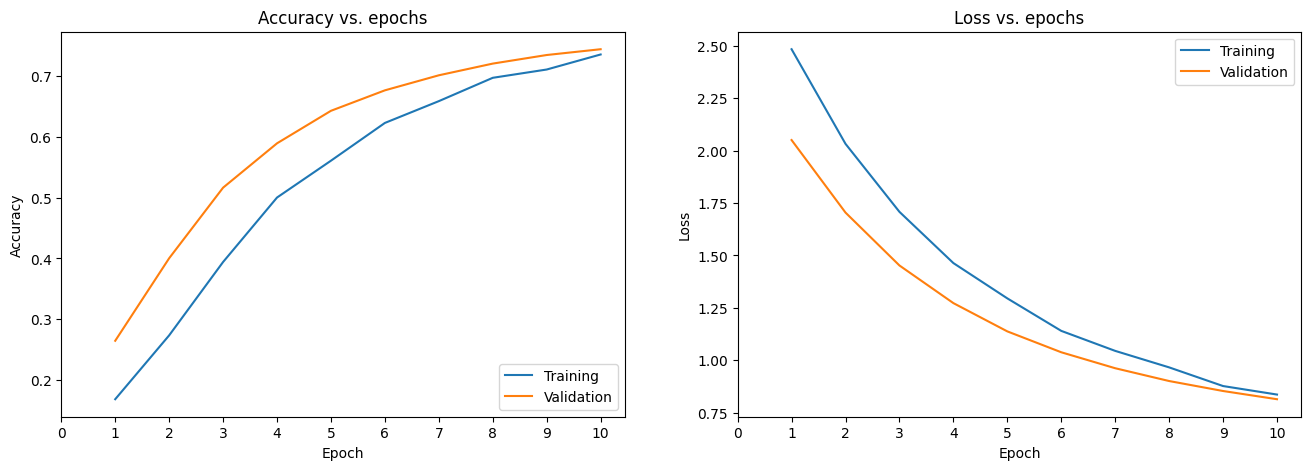

In [30]:
history = helper.train(model, epochs=10, callbacks=helper.get_callbacks(model, params.pretrained_callbacks))

In [31]:
model = fine_tuning(helper, model, base_model, fine_tune_at=100, learning_rate=0.00001)
print(f'len(model.trainable_variables)={len(model.trainable_variables)}')

len(model.trainable_variables)=56


2022-08-18 20:06:37,149: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/pretrained-MobileNetV2, monitor=val_accuracy)
2022-08-18 20:06:37,150: INFO: steps_per_epoch=62
2022-08-18 20:06:37,151: INFO: start training
2022-08-18 20:06:37,152: INFO: use_class_weight=False


Epoch 1/15
62/62 [==============================] - ETA: 0s - loss: 0.6990 - accuracy: 0.7515

2022-08-18 20:07:13,894: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/pretrained-MobileNetV2/assets


2022-08-18 20:07:19,067: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/pretrained-MobileNetV2/assets


62/62 [==============================] - 43s 609ms/step - loss: 0.6990 - accuracy: 0.7515 - val_loss: 0.6509 - val_accuracy: 0.7826
Epoch 2/15
62/62 [==============================] - ETA: 0s - loss: 0.5269 - accuracy: 0.8175

2022-08-18 20:07:48,381: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/pretrained-MobileNetV2/assets


2022-08-18 20:07:53,590: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/pretrained-MobileNetV2/assets


62/62 [==============================] - 34s 564ms/step - loss: 0.5269 - accuracy: 0.8175 - val_loss: 0.5991 - val_accuracy: 0.7966
Epoch 3/15
62/62 [==============================] - ETA: 0s - loss: 0.4301 - accuracy: 0.8438

2022-08-18 20:08:21,339: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/pretrained-MobileNetV2/assets


2022-08-18 20:08:26,642: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/pretrained-MobileNetV2/assets


62/62 [==============================] - 33s 541ms/step - loss: 0.4301 - accuracy: 0.8438 - val_loss: 0.5683 - val_accuracy: 0.8095
Epoch 4/15
62/62 [==============================] - ETA: 0s - loss: 0.3463 - accuracy: 0.8795

2022-08-18 20:08:53,015: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/pretrained-MobileNetV2/assets


2022-08-18 20:08:58,260: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/pretrained-MobileNetV2/assets


62/62 [==============================] - 32s 516ms/step - loss: 0.3463 - accuracy: 0.8795 - val_loss: 0.5482 - val_accuracy: 0.8171
Epoch 5/15
61/62 [============================>.] - ETA: 0s - loss: 0.2896 - accuracy: 0.9057

2022-08-18 20:09:23,942: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/pretrained-MobileNetV2/assets


2022-08-18 20:09:28,811: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/pretrained-MobileNetV2/assets


62/62 [==============================] - 31s 500ms/step - loss: 0.2920 - accuracy: 0.9037 - val_loss: 0.5307 - val_accuracy: 0.8231
Epoch 6/15
62/62 [==============================] - 9s 141ms/step - loss: 0.2367 - accuracy: 0.9249 - val_loss: 0.5442 - val_accuracy: 0.8207
Epoch 7/15
61/62 [============================>.] - ETA: 0s - loss: 0.1958 - accuracy: 0.9375

2022-08-18 20:10:03,373: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/pretrained-MobileNetV2/assets


2022-08-18 20:10:08,450: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/pretrained-MobileNetV2/assets


62/62 [==============================] - 31s 507ms/step - loss: 0.1959 - accuracy: 0.9375 - val_loss: 0.5221 - val_accuracy: 0.8297
Epoch 8/15
61/62 [============================>.] - ETA: 0s - loss: 0.1601 - accuracy: 0.9534

2022-08-18 20:10:34,349: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/pretrained-MobileNetV2/assets


2022-08-18 20:10:39,443: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/pretrained-MobileNetV2/assets


62/62 [==============================] - 31s 507ms/step - loss: 0.1594 - accuracy: 0.9536 - val_loss: 0.5111 - val_accuracy: 0.8349
Epoch 9/15
61/62 [============================>.] - ETA: 0s - loss: 0.1345 - accuracy: 0.9626

2022-08-18 20:11:05,065: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/pretrained-MobileNetV2/assets


2022-08-18 20:11:10,266: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/pretrained-MobileNetV2/assets


62/62 [==============================] - 31s 505ms/step - loss: 0.1333 - accuracy: 0.9632 - val_loss: 0.5239 - val_accuracy: 0.8365
Epoch 10/15
62/62 [==============================] - 9s 141ms/step - loss: 0.1078 - accuracy: 0.9682 - val_loss: 0.5336 - val_accuracy: 0.8335
Epoch 11/15
62/62 [==============================] - 13s 221ms/step - loss: 0.0929 - accuracy: 0.9738 - val_loss: 0.5695 - val_accuracy: 0.8304
Epoch 12/15
62/62 [==============================] - ETA: 0s - loss: 0.0767 - accuracy: 0.9803

2022-08-18 20:12:00,292: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/pretrained-MobileNetV2/assets


2022-08-18 20:12:05,545: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/pretrained-MobileNetV2/assets


62/62 [==============================] - 33s 541ms/step - loss: 0.0767 - accuracy: 0.9803 - val_loss: 0.5241 - val_accuracy: 0.8419
Epoch 13/15
62/62 [==============================] - 16s 269ms/step - loss: 0.0588 - accuracy: 0.9869 - val_loss: 0.5537 - val_accuracy: 0.8408
Epoch 14/15
62/62 [==============================] - 15s 242ms/step - loss: 0.0447 - accuracy: 0.9929 - val_loss: 0.5527 - val_accuracy: 0.8379
Epoch 15/15
61/62 [============================>.] - ETA: 0s - loss: 0.0397 - accuracy: 0.9939

2022-08-18 20:13:02,454: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/pretrained-MobileNetV2/assets


2022-08-18 20:13:07,247: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/pretrained-MobileNetV2/assets


62/62 [==============================] - 30s 497ms/step - loss: 0.0400 - accuracy: 0.9934 - val_loss: 0.5293 - val_accuracy: 0.8469


2022-08-18 20:13:07,991: INFO: finish training [elapsed time: 390.84 seconds]


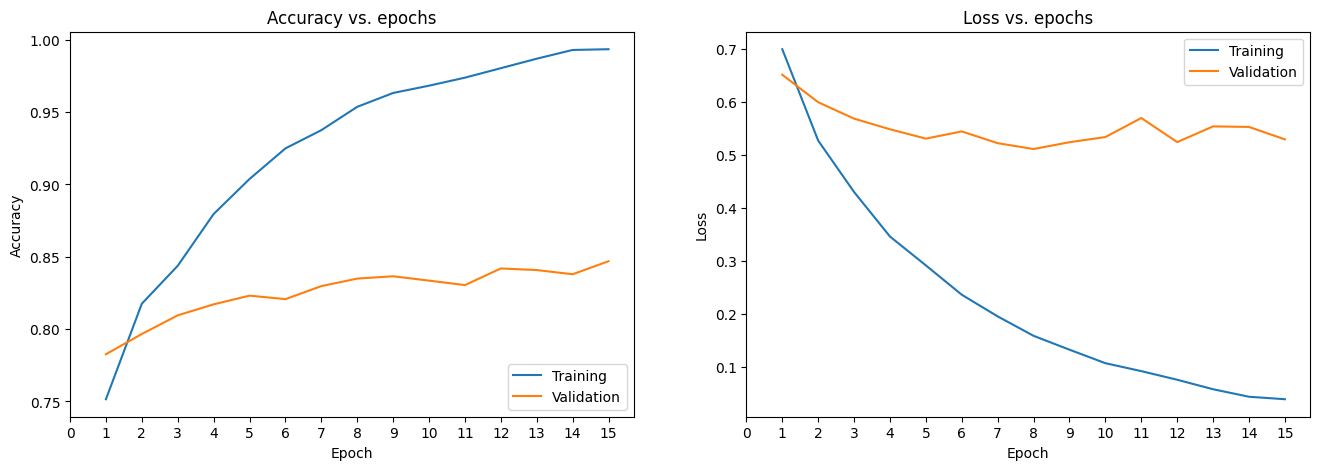

2022-08-18 20:13:08,388: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/pretrained-MobileNetV2


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/pretrained-MobileNetV2
----------------------------------------evaluate----------------------------------------
313/313 [==============================] - 12s 39ms/step


2022-08-18 20:13:50,623: INFO: test loss:0.5293
2022-08-18 20:13:50,624: INFO: test accuracy:0.8469
2022-08-18 20:13:50,627: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/results.json
2022-08-18 20:13:50,629: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/results.json
2022-08-18 20:13:50,629: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/default.generator
2022-08-18 20:13:50,630: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/default.generator


----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------
313/313 [==============================] - 8s 26ms/step


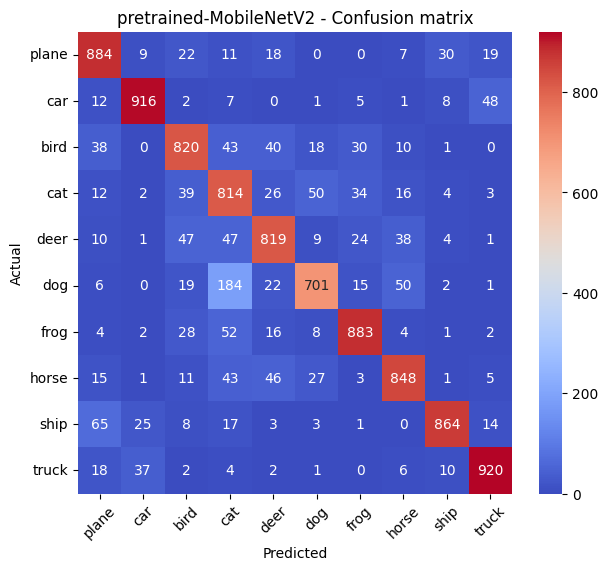

----------------------------------------models----------------------------------------


,model_name,program_name,weight_number,train_time,create_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc
1,pretrained-MobileNetV2,cifar10_0816_cnt_200.ipynb,1874250,390.8,2022-08-18 20:13,0.0187,0.5293,0.9995,0.8469,0.9999,0.9866


In [32]:
history = helper.train(model, epochs=15, callbacks=helper.get_callbacks(model, params.pretrained_callbacks))
helper.model_summary(model, history, show_sample_analysis=False) 

## Evaluation

### Best Model

In [33]:
data_model_results = qtf.classification.DataModelResults(params.data_path) 
data_model_results.show(10)

2022-08-18 20:13:59,639: INFO: getting results for /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10
2022-08-18 20:13:59,641: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/results.json
2022-08-18 20:13:59,642: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/results.json
2022-08-18 20:13:59,643: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/results.json
2022-08-18 20:13:59,644: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/results.json
2022-08-18 20:13:59,645: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/ima

,model_name,program_name,weight_number,train_time,create_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc
1,pretrained-MobileNetV2,cifar10_0816_cnt_5000_aug_1.ipynb,1874250,1414.6,2022-08-17 05:31,0.1048,0.2324,0.9630,0.9312,0.9992,0.9967
2,pretrained-MobileNetV2,cifar10_0816_cnt_5000.ipynb,1874250,1096.1,2022-08-16 12:32,0.0215,0.3150,0.9938,0.9260,1.0000,0.9964
3,pretrained-MobileNetV2,cifar10_0816_cnt_5000_aug.ipynb,1874250,1517.0,2022-08-17 06:29,0.1540,0.2510,0.9470,0.9199,0.9982,0.9958
4,pretrained-MobileNetV2,cifar10_0816_cnt_2000.ipynb,1874250,762.3,2022-08-16 11:22,0.0112,0.4282,0.9976,0.9058,1.0000,0.9944
5,pretrained-MobileNetV2,cifar10_0816_cnt_1000.ipynb,1874250,598.4,2022-08-16 09:26,0.0212,0.4112,0.9963,0.8930,1.0000,0.9929
6,vgg8,cifar10_0816_cnt_5000.ipynb,1672906,2113.1,2022-08-16 11:13,0.0005,0.8218,0.9999,0.8845,1.0000,0.9893
7,pretrained-MobileNetV2,cifar10_0816_cnt_500.ipynb,1874250,487.0,2022-08-16 09:53,0.0125,0.4696,0.9992,0.8778,1.0000,0.9906
8,pretrained-MobileNetV2,cifar10_0816_cnt_200.ipynb,1874250,390.8,2022-08-18 20:13,0.0187,0.5293,0.9995,0.8469,0.9999,0.9866
9,vgg8,cifar10_0816_cnt_2000.ipynb,1672906,1019.2,2022-08-16 10:31,0.0003,1.2263,1.0000,0.8299,1.0000,0.9791
10,resnet_v1_20,cifar10_0816_cnt_5000.ipynb,273066,2852.6,2022-08-16 12:02,0.1742,1.3372,0.9971,0.8207,1.0000,0.9796


In [34]:

predictors = qtf.classification.Predictor.get_top_n_predictors(5, data_model_results)

best_predictor = predictors[0]
best_predictor.model.compile(optimizer=optimizers.Adam(learning_rate=params.learning_rate),
                        loss=losses.SparseCategoricalCrossentropy(from_logits=True),
                        metrics=['accuracy', 'mae'])

qtf.utils.plot_model_structure(best_predictor.model)

2022-08-18 20:13:59,726: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug_1/pretrained-MobileNetV2
2022-08-18 20:14:10,109: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug_1/val_test.generator
2022-08-18 20:14:10,135: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/pretrained-MobileNetV2
2022-08-18 20:14:20,351: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/default.generator
2022-08-18 20:14:20,373: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000_aug/pretrained-MobileNetV2
2022-08-18 20:14:31,277: INFO: load

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


None

1/1 [==============================] - 1s 871ms/step


2022-08-18 20:14:55,426: WARNING: 5 out of the last 693 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7f06f230d4c0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 1s 898ms/step


2022-08-18 20:14:56,386: WARNING: 6 out of the last 694 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7f06f2151b80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 0s 18ms/step


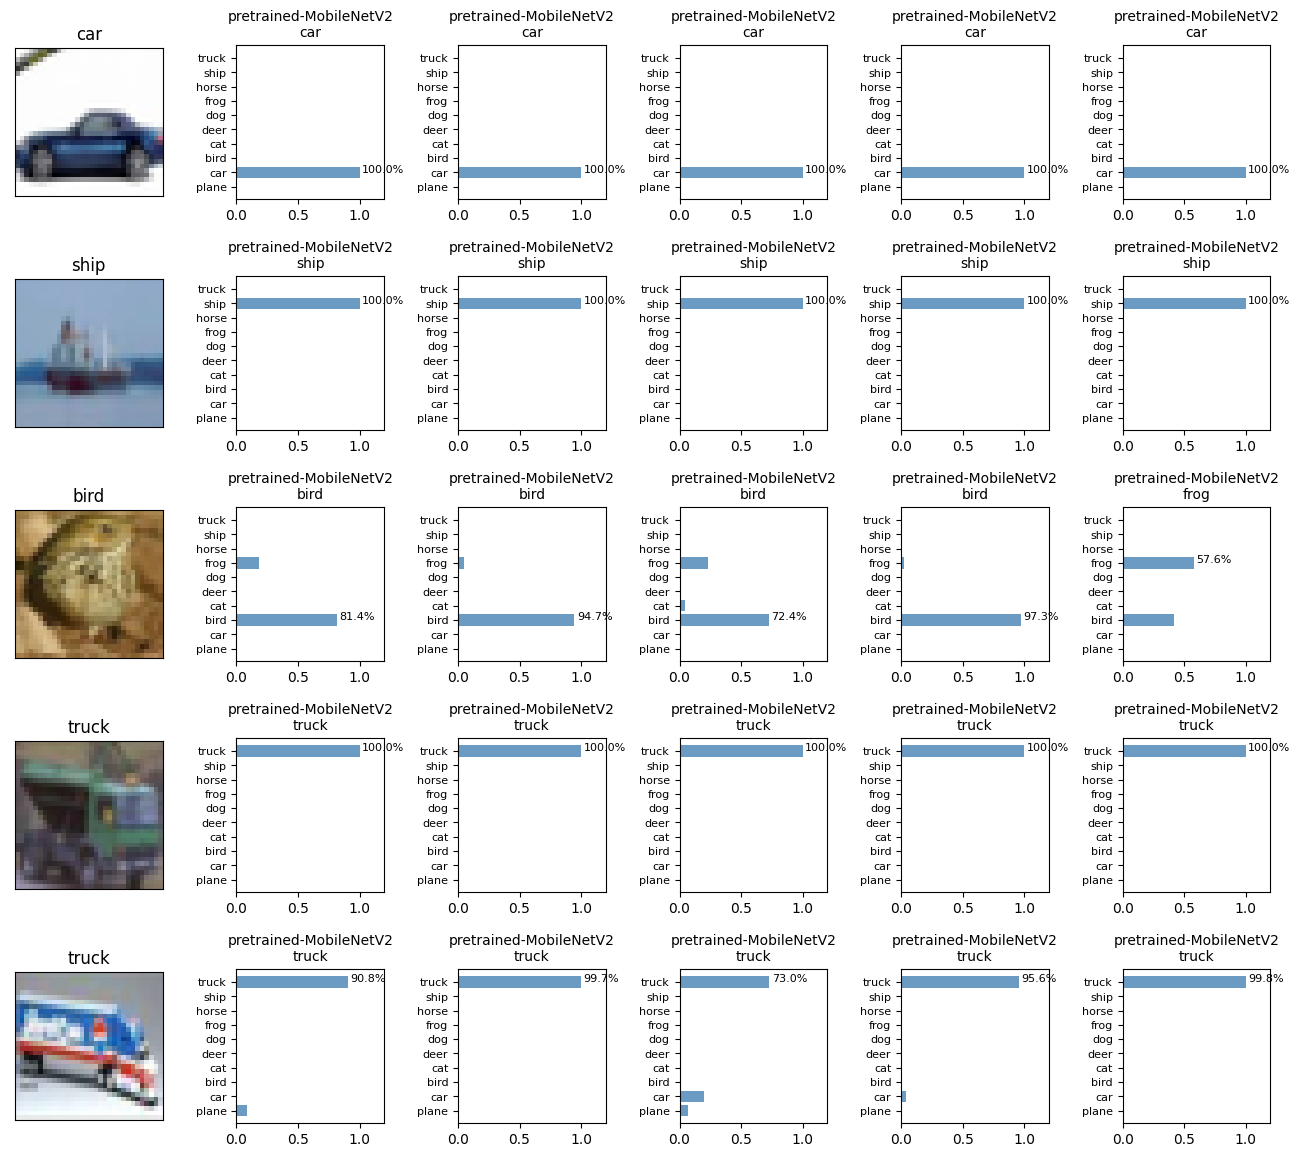

In [35]:
qtf.utils.plot_sample_image_analysis(predictors, test_images, test_labels,
                                    sample_count=5, show_error_sample=False) 

1/1 [==============================] - 0s 20ms/step


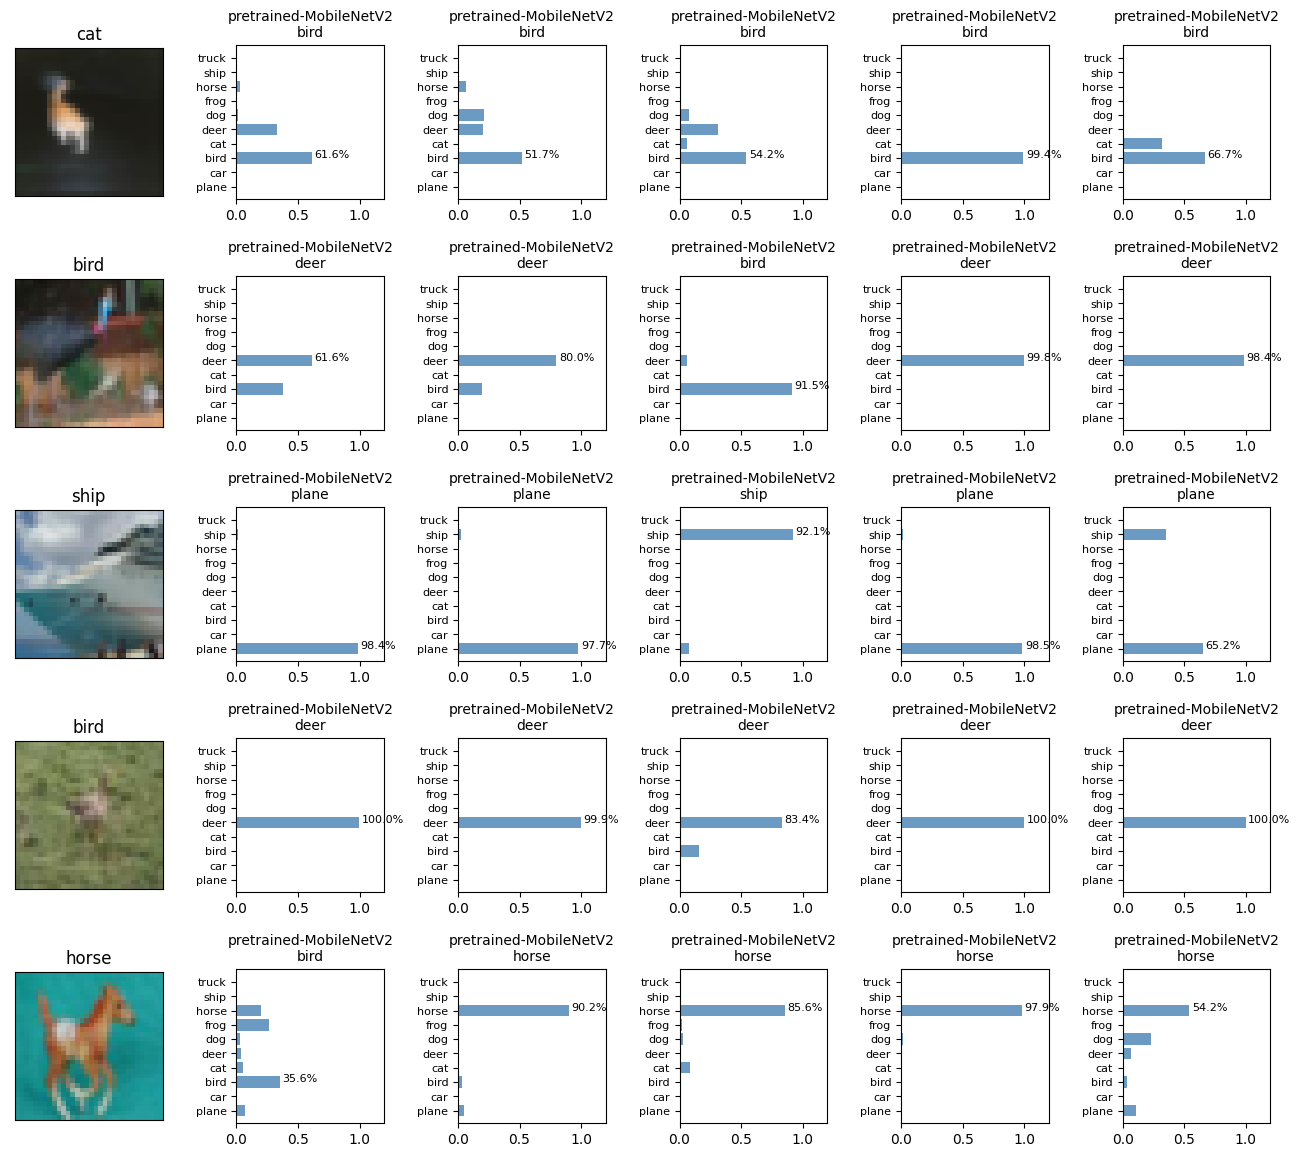

In [36]:
qtf.utils.plot_sample_image_analysis(predictors, test_images, test_labels,
                                    sample_count=5, show_error_sample=True) 

### Evaluate

In [37]:
results = best_predictor.evaluate(test_images, test_labels)
print(results)

predictions = best_predictor.predict(test_images)
print(predictions.shape)

{'loss': 0.23238687217235565, 'accuracy': 0.9312000274658203, 'mae': 10.514875411987305}
313/313 [==============================] - 12s 37ms/step
(10000, 10)


In [38]:
top1_predictions = best_predictor.predict_top_k(test_images, test_labels, top_k=1)
top1_scores = qtf.utils.score(test_labels, top1_predictions, params.classes)
display(top1_scores)
print('-'*100)
print(classification_report(test_labels, top1_predictions, digits=4, target_names=params.classes))

313/313 [==============================] - 7s 22ms/step


,precision,recall,f1
plane,0.910462,0.966,0.937409
car,0.978659,0.963,0.970766
bird,0.940268,0.913,0.926433
cat,0.881799,0.843,0.861963
deer,0.892823,0.933,0.912469
dog,0.929806,0.861,0.894081
frog,0.913938,0.977,0.944418
horse,0.952333,0.939,0.945619
ship,0.971282,0.947,0.958987
truck,0.944499,0.970,0.957079


----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

       plane     0.9105    0.9660    0.9374      1000
         car     0.9787    0.9630    0.9708      1000
        bird     0.9403    0.9130    0.9264      1000
         cat     0.8818    0.8430    0.8620      1000
        deer     0.8928    0.9330    0.9125      1000
         dog     0.9298    0.8610    0.8941      1000
        frog     0.9139    0.9770    0.9444      1000
       horse     0.9523    0.9390    0.9456      1000
        ship     0.9713    0.9470    0.9590      1000
       truck     0.9445    0.9700    0.9571      1000

    accuracy                         0.9312     10000
   macro avg     0.9316    0.9312    0.9309     10000
weighted avg     0.9316    0.9312    0.9309     10000



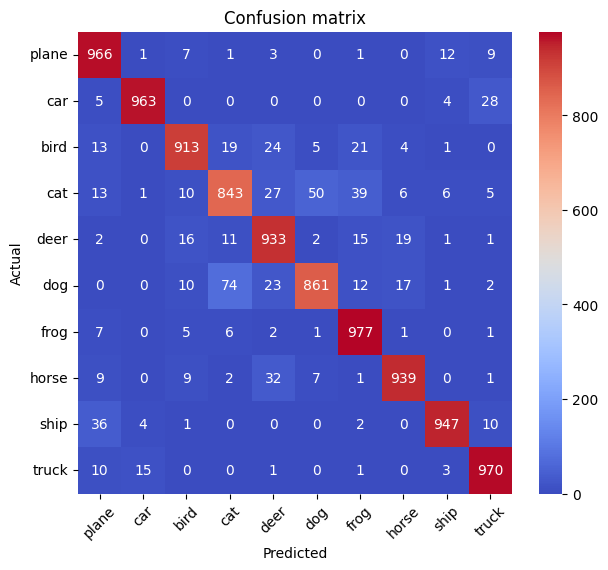

In [39]:
qtf.utils.plot_confusion_matrix(test_labels, top1_predictions, params.classes)


## Reference

- [Text classification Guide](https://developers.google.com/machine-learning/guides/text-classification)